# Readme

Our team is interested in whether the addition of a "distance from tourist attraction" variable would be helpful in predicting price of Airbnb. Our hypothesis is that it is true, as because most of the people on Airbnb are travellers, they would want to have a location near a tourist attraction as less travel and time would be needed!

Our Dataset initially contains 3672 rows and 73 columns!

Data is taken from:http://insideairbnb.com/singapore, it is a scrape of all the current listings on December 21st.
and https://data.gov.sg/dataset/tourist-attractions, it is a data set from the government for all tourist attraction locations!



# Data Preparation

### Import Libraries and Datasets
Importing the necessary libraries and datasets that will be used.

In [1]:
# Necessary libraries
!pip install pandas fiona shapely pyproj rtree
!pip install pygeos
!pip install geopandas
!pip install contextily
!pip install xgboost
!pip install graphviz
!pip install wordcloud

     |████████████████████████████████| 16.7 MB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 63.5 MB/s 
     |████████████████████████████████| 1.0 MB 51.7 MB/s 
     |████████████████████████████████| 2.1 MB 4.4 MB/s 
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [2]:
# Import
import pandas as pd
import geopandas as gp
import contextily as cx
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from scipy import stats
sb.set() # set the default Seaborn style for graphics

# Tourism Data
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
#tourism_df = gp.read_file('https://raw.githubusercontent.com/lwklhj/SC1015-Project/main/data/TOURISM.kml', driver='KML')
tourism_df = gp.read_file('data/TOURISM.kml', driver='KML')

#tourism_df = gp.read_file('mrtlta.kml', driver='KML')

# Airbnb Data
#airbnb_df = pd.read_csv('https://raw.githubusercontent.com/lwklhj/SC1015-Project/main/data/listings.csv')
airbnb_df = pd.read_csv('data/listings.csv')
airbnb_df = gp.GeoDataFrame(
    airbnb_df, geometry=gp.points_from_xy(airbnb_df['longitude'], airbnb_df['latitude']), crs='EPSG:4326')
airbnb_df = airbnb_df.drop(columns=['latitude', 'longitude'])

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Data Preparation: Airbnb

Taking a preliminary look at the Airbnb data.

In [3]:
airbnb_df.head()

id                          listing_url       scrape_id last_scraped  \
0   50646   https://www.airbnb.com/rooms/50646  20211226165704   2021-12-27   
1   71609   https://www.airbnb.com/rooms/71609  20211226165704   2021-12-27   
2   71896   https://www.airbnb.com/rooms/71896  20211226165704   2021-12-27   
3   71903   https://www.airbnb.com/rooms/71903  20211226165704   2021-12-27   
4  275343  https://www.airbnb.com/rooms/275343  20211226165704   2021-12-27   

                                               name  \
0                   Pleasant Room along Bukit Timah   
1               Ensuite Room (Room 1 & 2) near EXPO   
2                   B&B  Room 1 near Airport & EXPO   
3                        Room 2-near Airport & EXPO   
4  Conveniently located City Room!(1,2,3,4,5,6,7,8)   

                                         description  \
0  Fully furnished bedroom with a nice view on th...   
1  For 3 rooms.Book room 1&2 and room 4<br /><br ...   
2  <b>The space</b><br />Vocational Stay Deluxe B...   
3  Like your own home, 24hrs access.<br /><br /><...   
4  Awesome location and host <br />Room near INSE...   

                               neighborhood_overview  \
0  The serenity & quiet surrounding makes it an i...   
1                                                NaN   
2                                                NaN   
3  Quiet and view of the playground with exercise...   
4                                                NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/36342984/670d...   227796   
1  https://a0.muscache.com/pictures/24453191/3580...   367042   
2  https://a0.muscache.com/pictures/2440674/ac4f4...   367042   
3  https://a0.muscache.com/pictures/568743/7bc623...   367042   
4  https://a0.muscache.com/pictures/11979330/9bbd...  1439258   

                                    host_url  ... review_scores_location  \
0   https://www.airbnb.com/users/show/227796  ...                   4.72   
1   https://www.airbnb.com/users/show/367042  ...                   4.26   
2   https://www.airbnb.com/users/show/367042  ...                   4.17   
3   https://www.airbnb.com/users/show/367042  ...                   4.50   
4  https://www.airbnb.com/users/show/1439258  ...                   4.53   

  review_scores_value license instant_bookable calculated_host_listings_count  \
0                4.50     NaN                f                              1   
1                4.32     NaN                f                              5   
2                4.04     NaN                f                              5   
3                4.36     NaN                f                              5   
4                4.59   S0399                f                             16   

  calculated_host_listings_count_entire_homes  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            5   
2                                            5   
3                                            5   
4                                           15   

  calculated_host_listings_count_shared_rooms reviews_per_month  \
0                                           0              0.19   
1                                           0              0.16   
2                                           0              0.19   
3                                           0              0.36   
4                                           0              0.19   

                    geometry  
0  POINT (103.78521 1.33432)  
1  POINT (103.95887 1.34537)  
2  POINT (103.95958 1.34754)  
3  POINT (103.96100 1.34531)  
4  POINT (103.80814 1.29015)  

[5 row

This gives an insight on the type of possible variables to be used as predictors for the price of Airbnb. Can also observe that some columns have non-null values and the different data types to be taken into account during data cleaning.

In [4]:
airbnb_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            3672 non-null   int64   
 1   listing_url                                   3672 non-null   object  
 2   scrape_id                                     3672 non-null   int64   
 3   last_scraped                                  3672 non-null   object  
 4   name                                          3672 non-null   object  
 5   description                                   3555 non-null   object  
 6   neighborhood_overview                         2373 non-null   object  
 7   picture_url                                   3672 non-null   object  
 8   host_id                                       3672 non-null   int64   
 9   host_url                                    

In [5]:
airbnb_df.shape

(3672, 73)

### Checking for null or missing data

Null or missing data needs to be filled or removed.

In [6]:
airbnb_df.isnull().sum()[airbnb_df.isnull().sum() > 0]

description                     117
neighborhood_overview          1299
host_name                        11
host_since                       11
host_location                    11
host_about                     1222
host_response_time              454
host_response_rate              454
host_acceptance_rate            728
host_is_superhost                11
host_thumbnail_url               11
host_picture_url                 11
host_neighbourhood              323
host_listings_count              11
host_total_listings_count        11
host_has_profile_pic             11
host_identity_verified           11
neighbourhood                  1299
bathrooms                      3672
bathrooms_text                   29
bedrooms                        417
beds                            130
minimum_minimum_nights            1
maximum_minimum_nights            1
minimum_maximum_nights            1
maximum_maximum_nights            1
minimum_nights_avg_ntm            1
maximum_nights_avg_ntm      

In [7]:
sb.set(rc={'figure.figsize':(19.7,8.27)})

sb.heatmap(airbnb_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Selection of variables 
#### Variables will not be used thus columns will be dropped:
1.   Data has natural language
      *   e.g. description
2.   More than half of data is null/missing
      *   e.g. bathrooms, calendar_updated
3.   Irrelevant data:
      *   Cannot be used to predict price
            *   e.g. listing_uri, scrape_id, last_scraped, host_id, first_review
      *  neighbourhood only has variants of 'Singapore' as data, using neighbourhood_cleansed and neighbourhood_group_cleansed instead

#### Variables that can affect the price to be kept:
*   Location of the place
      *   neighbourhood_cleansed & neighbourhood_group_cleansed
*   Type of house and what it has
      *   property_type
      *   room_type
      *   accommodates
      *   bedrooms
      *   beds
*   Miscellaneous
      *   minimum_nights
      *   availability_365
      *   number_of_reviews
      *   calculated_host_listings_count
      *   price







In [8]:
airbnb_df = airbnb_df[['neighbourhood_cleansed','neighbourhood_group_cleansed','property_type','room_type','accommodates','bedrooms','beds','price','minimum_nights','availability_365','number_of_reviews','calculated_host_listings_count','geometry']]

### Data Cleaning: Beds and Bedrooms

Some of the beds and bedrooms values are filled with NaNs, in order to clean it, the rows with NaN values for beds and bedrooms will be dropped.

In [9]:
airbnb_df.isnull().sum()

neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                          417
beds                              130
price                               0
minimum_nights                      0
availability_365                    0
number_of_reviews                   0
calculated_host_listings_count      0
geometry                            0
dtype: int64

In [10]:
airbnb_df.dropna(subset=['bedrooms','beds' ], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [11]:
airbnb_df.isna().sum()

neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
property_type                     0
room_type                         0
accommodates                      0
bedrooms                          0
beds                              0
price                             0
minimum_nights                    0
availability_365                  0
number_of_reviews                 0
calculated_host_listings_count    0
geometry                          0
dtype: int64

### Data Cleaning: Price

Price of the rental itself is stored as a string such as '\$23.00', to make it easier to work with the data, regular expression is used to remove '$' and the data is to be stored as a float instead.

In [12]:
airbnb_df['price'] = airbnb_df['price'].replace('[\$,]', '', regex=True).astype(float)
airbnb_df.info()
#airbnb_df[airbnb_df.isna().any(axis=1)]

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3154 entries, 0 to 3671
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   neighbourhood_cleansed          3154 non-null   object  
 1   neighbourhood_group_cleansed    3154 non-null   object  
 2   property_type                   3154 non-null   object  
 3   room_type                       3154 non-null   object  
 4   accommodates                    3154 non-null   int64   
 5   bedrooms                        3154 non-null   float64 
 6   beds                            3154 non-null   float64 
 7   price                           3154 non-null   float64 
 8   minimum_nights                  3154 non-null   int64   
 9   availability_365                3154 non-null   int64   
 10  number_of_reviews               3154 non-null   int64   
 11  calculated_host_listings_count  3154 non-null   int64   
 12  geometry    

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Data Preparation: Tourist Attractions

Taking a preliminary look at the tourist attractions data.

In [13]:
tourism_df.head()

Name  \
0  www.yoursingapore.com/en/see-do-singapore/cult...   
1  www.yoursingapore.com/en/see-do-singapore/cult...   
2  www.yoursingapore.com/en/see-do-singapore/cult...   
3  www.yoursingapore.com/en/see-do-singapore/arch...   
4  www.yoursingapore.com/en/see-do-singapore/arch...   

                                         Description  \
0  <html xmlns:fo="http://www.w3.org/1999/XSL/For...   
1  <html xmlns:fo="http://www.w3.org/1999/XSL/For...   
2  <html xmlns:fo="http://www.w3.org/1999/XSL/For...   
3  <html xmlns:fo="http://www.w3.org/1999/XSL/For...   
4  <html xmlns:fo="http://www.w3.org/1999/XSL/For...   

                              geometry  
0  POINT Z (103.84435 1.28351 0.00000)  
1  POINT Z (103.84763 1.28094 0.00000)  
2  POINT Z (103.89942 1.31007 0.00000)  
3  POINT Z (103.83734 1.27722 0.00000)  
4  POINT Z (103.84142 1.27549 0.00000)

In [14]:
tourism_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         106 non-null    object  
 1   Description  106 non-null    object  
 2   geometry     106 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 2.6+ KB


In [15]:
tourism_df.isnull().sum()

Name           0
Description    0
geometry       0
dtype: int64

There are no null values.

In [16]:
f, axes = plt.subplots(1, 2, figsize=(20, 10))

ax1 = airbnb_df.plot(column=airbnb_df.neighbourhood_cleansed, ax = axes[0])
ax1.set_title("Airbnb Locations")
cx.add_basemap(ax1, crs=airbnb_df.crs.to_string())

#airbnb_df.plot(column=airbnb_df.neighbourhood_group, ax = axes[0])
ax2 = tourism_df.plot(ax = axes[1])
ax2.set_title("Tourist Attractions")
cx.add_basemap(ax2, crs=tourism_df.crs.to_string())

Data seems complete, no need to modify data


---

# Exploratory Data Analysis

Checking the cleaned dataset.

In [17]:
airbnb_df.head()

neighbourhood_cleansed neighbourhood_group_cleansed  \
0            Bukit Timah               Central Region   
1               Tampines                  East Region   
2               Tampines                  East Region   
3               Tampines                  East Region   
4            Bukit Merah               Central Region   

                      property_type     room_type  accommodates  bedrooms  \
0       Private room in rental unit  Private room             2       1.0   
1             Private room in villa  Private room             6       2.0   
2  Private room in residential home  Private room             3       1.0   
3  Private room in residential home  Private room             3       1.0   
4       Private room in rental unit  Private room             1       1.0   

   beds  price  minimum_nights  availability_365  number_of_reviews  \
0   1.0   80.0              90               365                 18   
1   3.0  179.0              92               365                 20   
2   1.0   82.0              92               365                 24   
3   2.0   82.0              92               365                 47   
4   1.0   52.0              14               341                 20   

   calculated_host_listings_count                   geometry  
0                               1  POINT (103.78521 1.33432)  
1                               5  POINT (103.95887 1.34537)  
2                               5  POINT (103.95958 1.34754)  
3                               5  POINT (103.96100 1.34531)  
4                              16  POINT (103.80814 1.29015)

Outliers are removed in order to clean the data to obtain more statistically significant results.

In [18]:
def get_num_outliers(column):
  Q1 = np.percentile(column, 25)
  Q3 = np.percentile(column, 75)
  IQR = Q3 - Q1
  return sum((column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR)))
  
def getOutliers(column):
  Q1 = np.percentile(column, 25)
  Q3 = np.percentile(column, 75)
  IQR = Q3 - Q1
  return column[(column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))]

def remove_outlier(df_in, col_name):
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  return df_out

def remove_outliers_zscore(df_in, col_name):
  return df_in[(np.abs(stats.zscore(df_in[col_name])) < 3)]

So lets first take a quick look at their histograms

In [19]:
row = 0
column = 0
numeric_data = pd.DataFrame(airbnb_df[["accommodates", "bedrooms", "beds", "minimum_nights", "availability_365", "number_of_reviews", "calculated_host_listings_count", "price"]])
f, axes = plt.subplots(4, 2, figsize=(20, 15))
for var in numeric_data:
    sb.histplot(data = numeric_data[var], ax = axes[row, column], kde = True)
    column += 1
    if column > 1:
      column = 0
      row += 1

In [20]:
print("accommodates outliers:\t\t\t", get_num_outliers(airbnb_df["accommodates"]))
print("bedrooms outliers:\t\t\t", get_num_outliers(airbnb_df["bedrooms"]))
print("beds outliers:\t\t\t\t", get_num_outliers(airbnb_df["beds"]))
print("minimum_nights outliers:\t\t", get_num_outliers(airbnb_df["minimum_nights"]))
print("availability_365 outliers:\t\t", get_num_outliers(airbnb_df["availability_365"]))
print("number_of_reviews outliers:\t\t", get_num_outliers(airbnb_df["number_of_reviews"]))
print("calculated_host_listings_count outliers:", get_num_outliers(airbnb_df["calculated_host_listings_count"]))
print("price outliers:\t\t\t\t", get_num_outliers(airbnb_df["price"]))

accommodates outliers:			 131
bedrooms outliers:			 755
beds outliers:				 319
minimum_nights outliers:		 34
availability_365 outliers:		 0
number_of_reviews outliers:		 511
calculated_host_listings_count outliers: 338
price outliers:				 255


In [21]:
airbnb_df.corr()

accommodates  bedrooms      beds     price  \
accommodates                        1.000000  0.520516  0.730338  0.184538   
bedrooms                            0.520516  1.000000  0.259409  0.256708   
beds                                0.730338  0.259409  1.000000  0.071878   
price                               0.184538  0.256708  0.071878  1.000000   
minimum_nights                     -0.098334  0.020818 -0.093905 -0.066264   
availability_365                   -0.006426  0.096852 -0.010883  0.056233   
number_of_reviews                   0.043900 -0.073221  0.026836 -0.069028   
calculated_host_listings_count      0.069684  0.242400 -0.020712  0.113302   

                                minimum_nights  availability_365  \
accommodates                         -0.098334         -0.006426   
bedrooms                              0.020818          0.096852   
beds                                 -0.093905         -0.010883   
price                                -0.066264          0.056233   
minimum_nights                        1.000000         -0.015323   
availability_365                     -0.015323          1.000000   
number_of_reviews                    -0.028101         -0.113500   
calculated_host_listings_count       -0.044270          0.294830   

                                number_of_reviews  \
accommodates                             0.043900   
bedrooms                                -0.073221   
beds                                     0.026836   
price                                   -0.069028   
minimum_nights                          -0.028101   
availability_365                        -0.113500   
number_of_reviews                        1.000000   
calculated_host_listings_count          -0.182747   

                                calculated_host_listings_count  
accommodates                                          0.069684  
bedrooms                                              0.242400  
beds                                                 -0.020712  
price                                                 0.113302  
minimum_nights                                       -0.044270  
availability_365                                      0.294830  
number_of_reviews                                    -0.182747  
calculated_host_listings_count                        1.000000

In [22]:
airbnb_df = remove_outliers_zscore(airbnb_df, 'accommodates')
airbnb_df = remove_outliers_zscore(airbnb_df, 'bedrooms')
airbnb_df = remove_outliers_zscore(airbnb_df, 'beds')
airbnb_df = remove_outliers_zscore(airbnb_df, 'minimum_nights')
#airbnb_df = remove_outliers_zscore(airbnb_df, 'availability_365')
airbnb_df = remove_outliers_zscore(airbnb_df, 'number_of_reviews')
airbnb_df = remove_outliers_zscore(airbnb_df, 'calculated_host_listings_count')
airbnb_df = remove_outliers_zscore(airbnb_df, 'price')

In [23]:
row = 0
column = 0
numeric_data = pd.DataFrame(airbnb_df[["accommodates", "bedrooms", "beds", "minimum_nights", "availability_365", "number_of_reviews", "calculated_host_listings_count", "price"]])
f, axes = plt.subplots(4, 2, figsize=(20, 15))
for var in numeric_data:
    sb.histplot(data = numeric_data[var], ax = axes[row, column], kde = True)
    column += 1
    if column > 1:
      column = 0
      row += 1

In [24]:
airbnb_df.corr()

accommodates  bedrooms      beds     price  \
accommodates                        1.000000  0.750837  0.768423  0.502372   
bedrooms                            0.750837  1.000000  0.663426  0.481157   
beds                                0.768423  0.663426  1.000000  0.385673   
price                               0.502372  0.481157  0.385673  1.000000   
minimum_nights                     -0.077989  0.018323 -0.068986 -0.214645   
availability_365                    0.042731  0.097876  0.029868  0.157678   
number_of_reviews                  -0.003958 -0.083264 -0.025605 -0.119020   
calculated_host_listings_count      0.170290  0.287232  0.094285  0.275835   

                                minimum_nights  availability_365  \
accommodates                         -0.077989          0.042731   
bedrooms                              0.018323          0.097876   
beds                                 -0.068986          0.029868   
price                                -0.214645          0.157678   
minimum_nights                        1.000000          0.019086   
availability_365                      0.019086          1.000000   
number_of_reviews                    -0.003052         -0.150154   
calculated_host_listings_count       -0.011685          0.294967   

                                number_of_reviews  \
accommodates                            -0.003958   
bedrooms                                -0.083264   
beds                                    -0.025605   
price                                   -0.119020   
minimum_nights                          -0.003052   
availability_365                        -0.150154   
number_of_reviews                        1.000000   
calculated_host_listings_count          -0.208778   

                                calculated_host_listings_count  
accommodates                                          0.170290  
bedrooms                                              0.287232  
beds                                                  0.094285  
price                                                 0.275835  
minimum_nights                                       -0.011685  
availability_365                                      0.294967  
number_of_reviews                                    -0.208778  
calculated_host_listings_count                        1.000000

In [25]:
airbnb_df.shape

(2915, 13)

After removing outliers, correlation to price have improved!
<br>Next, the different variables will be explored. 

### Price Variable

Table that shows the distribution of price of Airbnbs.

In [26]:
airbnb_df['price'].describe()

count    2915.000000
mean      188.046312
std       179.734828
min        13.000000
25%        69.000000
50%       137.000000
75%       224.500000
max      1414.000000
Name: price, dtype: float64

Visualise the data using boxplot.

In [27]:
f = plt.figure(figsize=(12, 6))
sb.boxplot(data = airbnb_df['price'], orient = "h")

### Neighbourhood Variable

Taking a look at the distribution of Airbnbs in the neighbourhoods.

In [28]:
sb.catplot(y = "neighbourhood_cleansed", data = airbnb_df, kind = "count", height = 16)

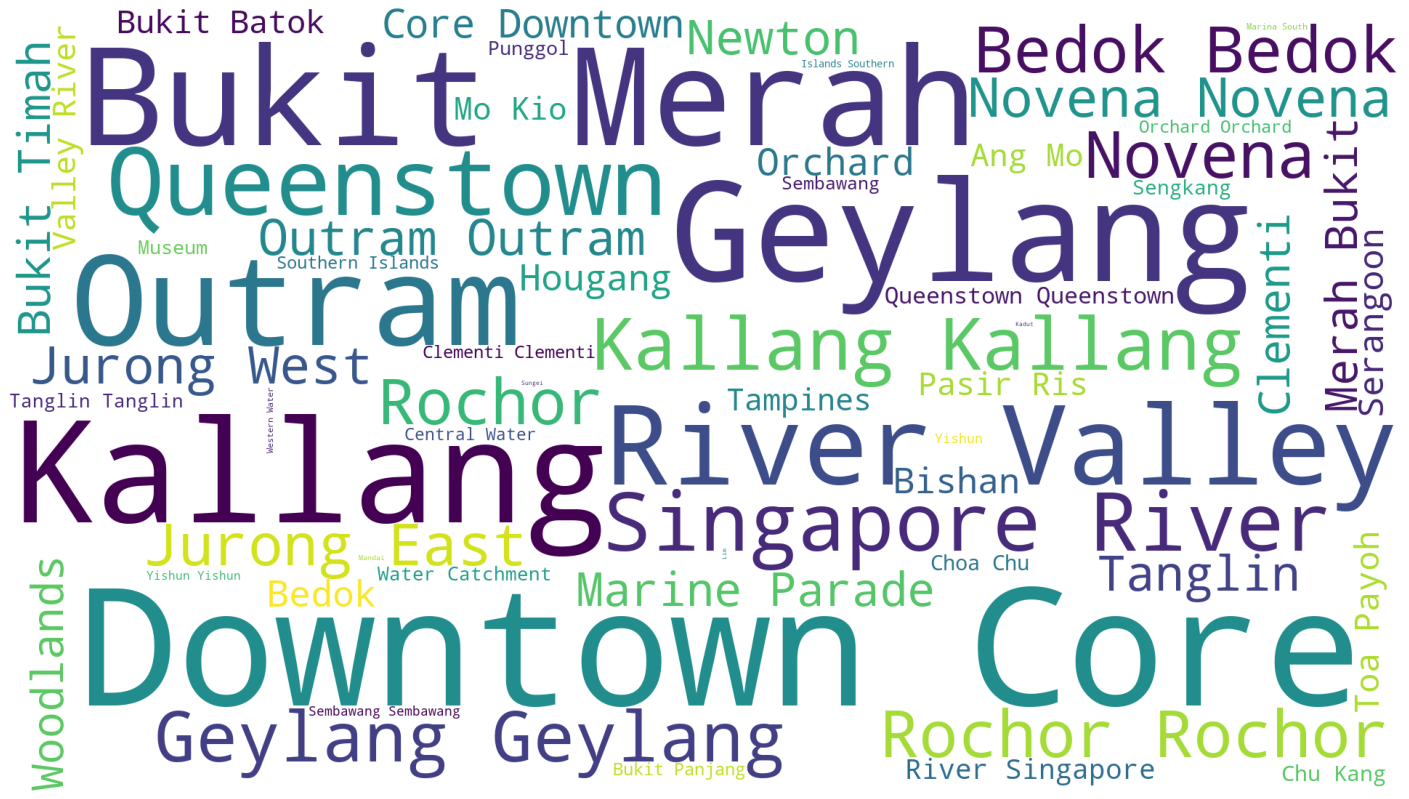

In [29]:
from wordcloud import WordCloud
plt.subplots(figsize=(25,15))

wordcloud = WordCloud(background_color='white',width=1920,height=1080).generate(" ".join(airbnb_df.neighbourhood_cleansed))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Comparing the neighbourhood in relation to the price.

In [30]:
ax = sb.catplot(x="neighbourhood_cleansed", y="price", kind="box",legend=True, data=airbnb_df,height=20)
ax.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

It can be observed that the different neighbourhoods vary a lot in pricing with some having higher medians such as Orchard or Queenstown while others have lower medians such as Bukit Panjang and Ang Mo Kio.

### Neighbourhood Group Variable

Taking a look at the distribution of Airbnbs in the neighbourhoods groups.

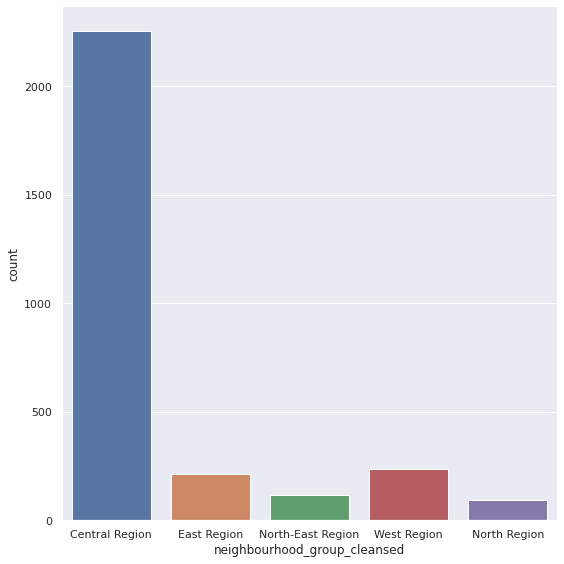

In [31]:
sb.catplot(x = "neighbourhood_group_cleansed", data = airbnb_df, kind = "count", height = 8)

Comparing the neighbourhood groups in relation to the price.

In [32]:
ax = sb.catplot(x="neighbourhood_group_cleansed", y="price", kind="box",legend=True, data=airbnb_df,height=20)
ax.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

It can be observed that the different neighbourhood groups do not vary as much in pricing but the Central Region has the highest median.

### Proprerty Type Variable


Taking a look at the distribution of the different types of properties for Airbnbs.

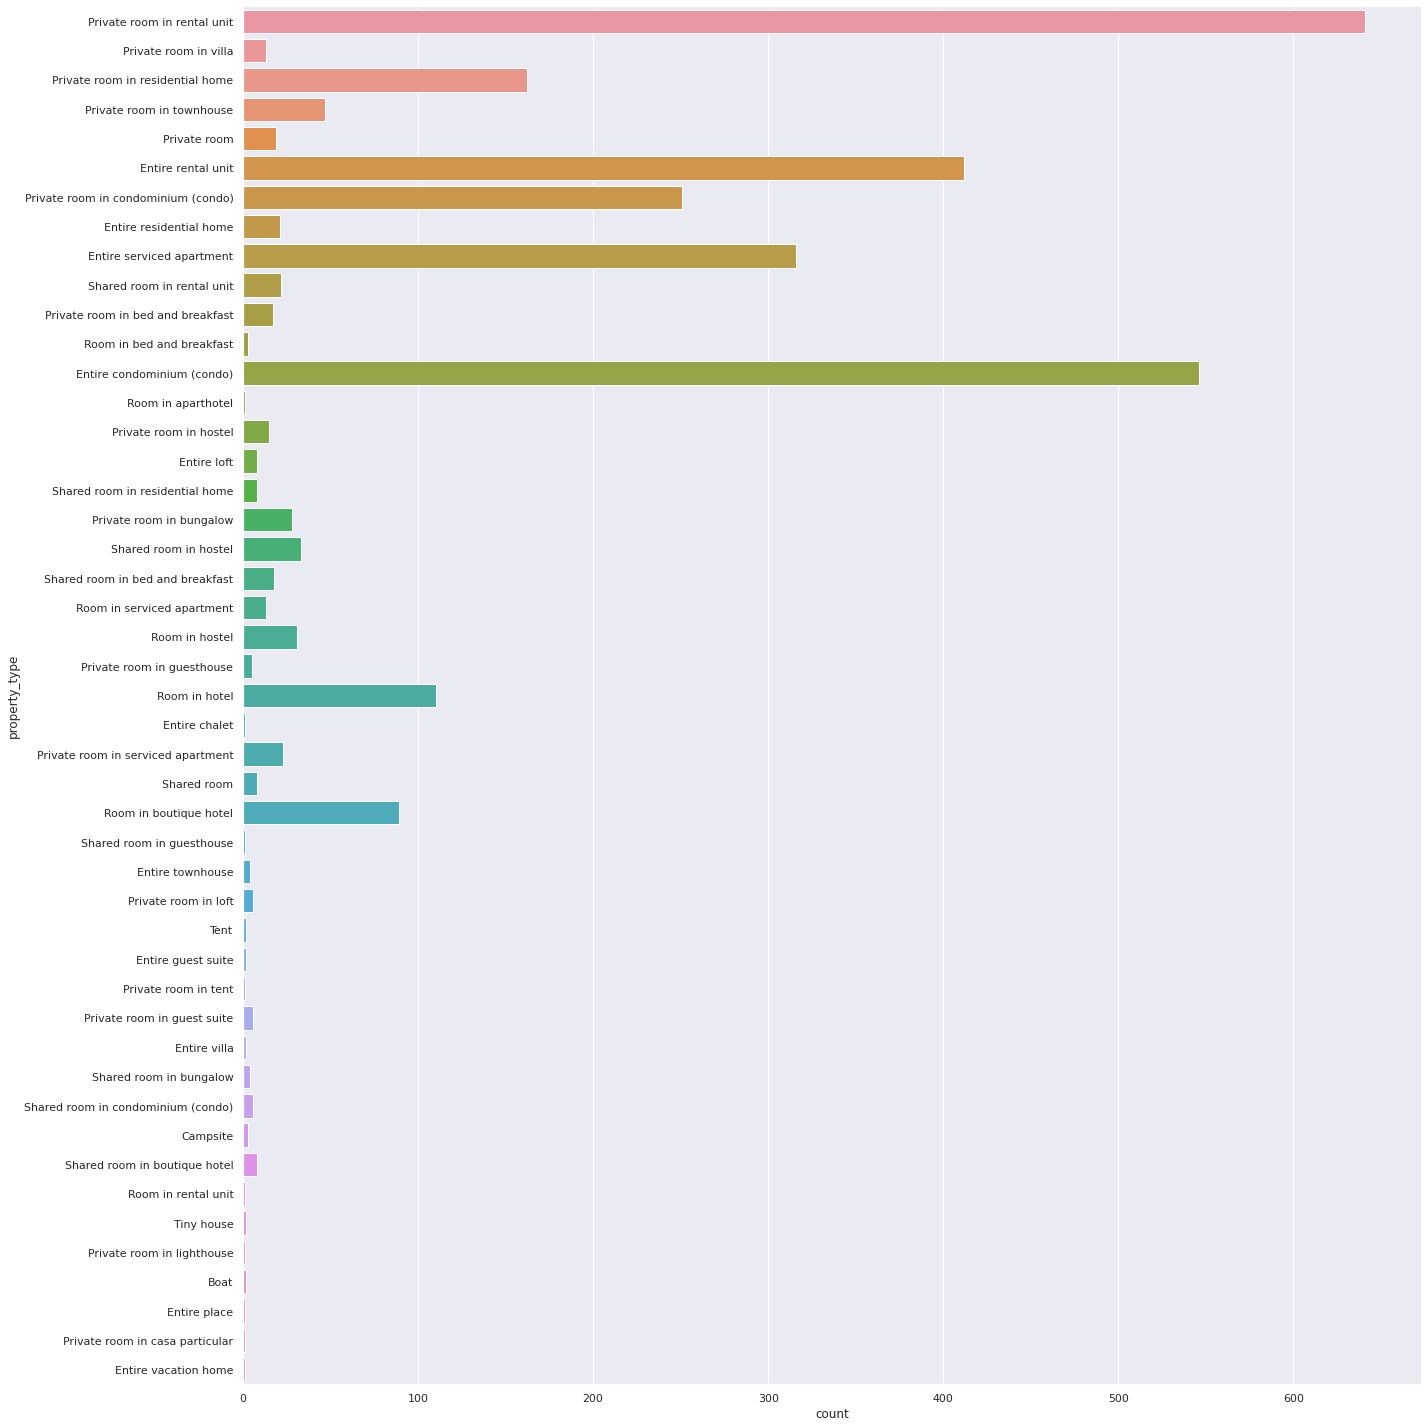

In [33]:
sb.catplot(y = "property_type", data = airbnb_df, kind = "count", height = 20)

Comparing the property types in relation to the price.

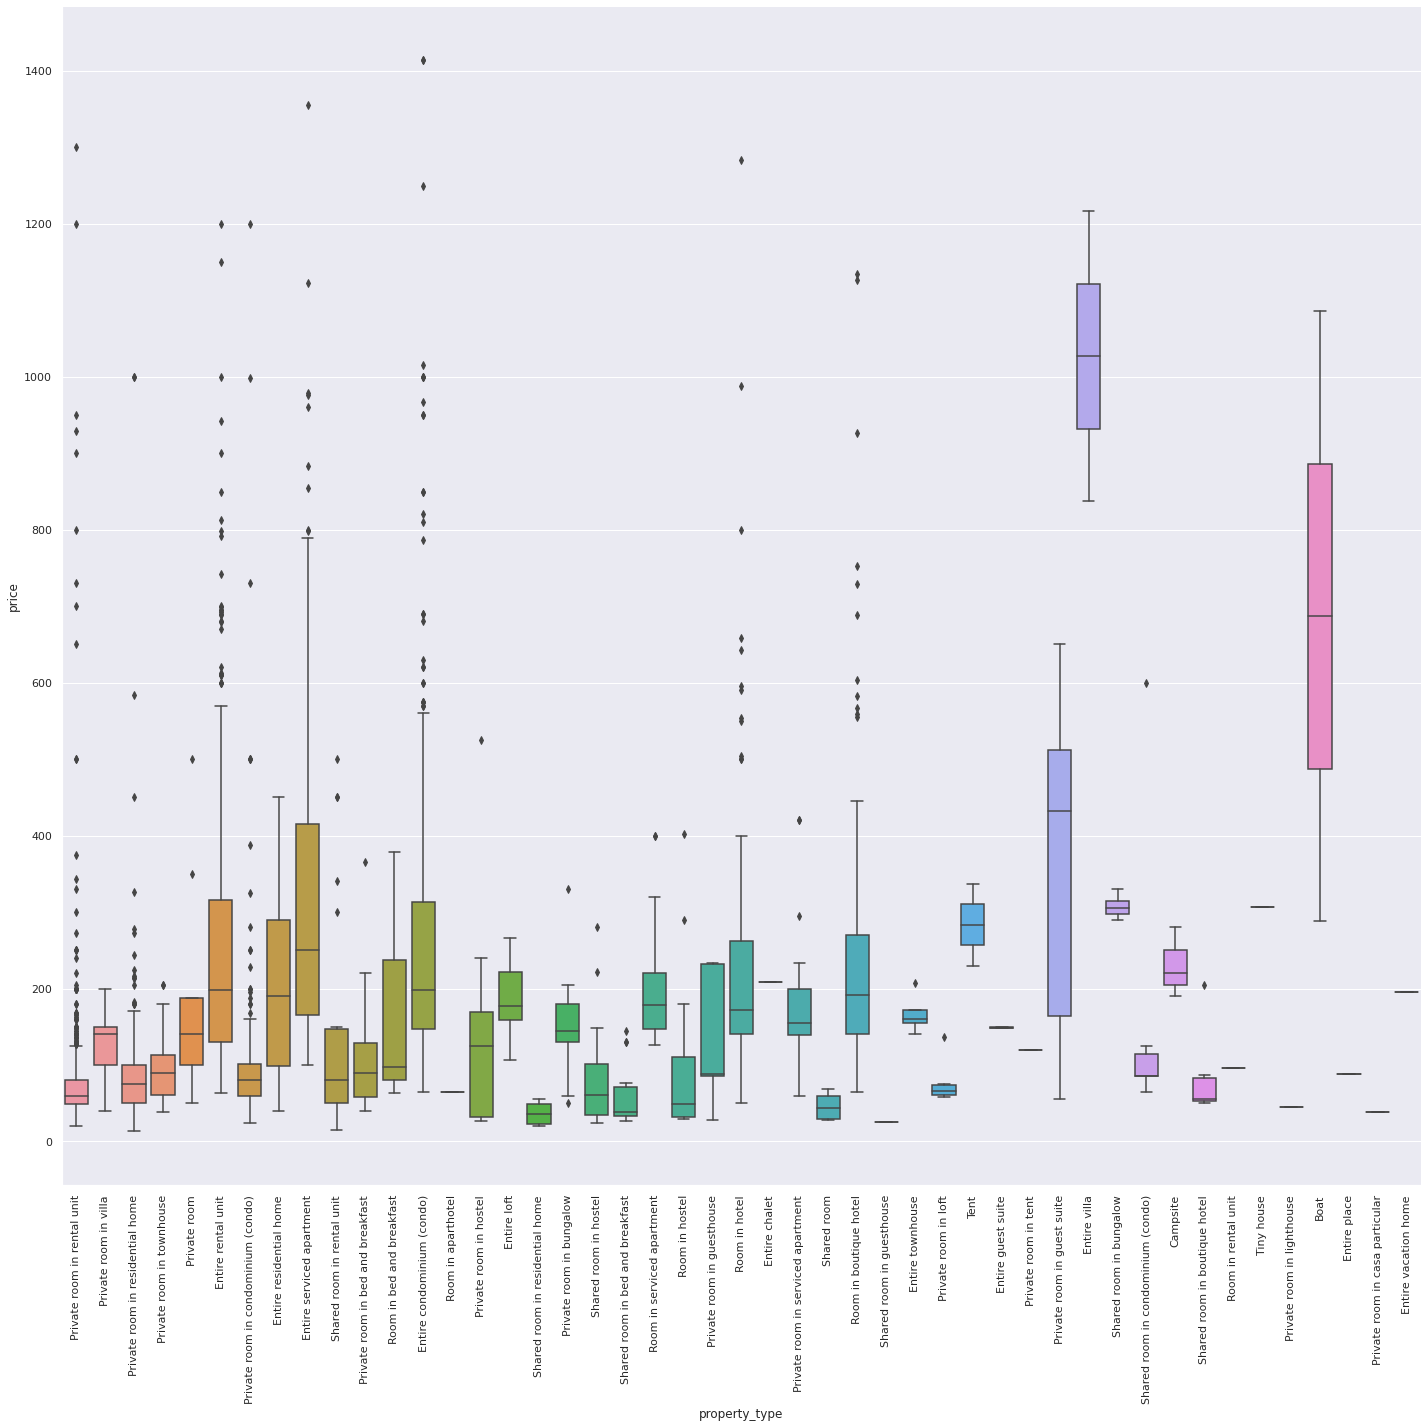

In [34]:
ax = sb.catplot(x="property_type", y="price", kind="box",legend=True, data=airbnb_df,height=20)
ax.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

Even though there is a huge variation in the price based on the property type, sample size for some of the property types are too low for the results to be reliable.  

### Room Type Variable


Taking a look at the distribution of the different types of rooms for Airbnbs.

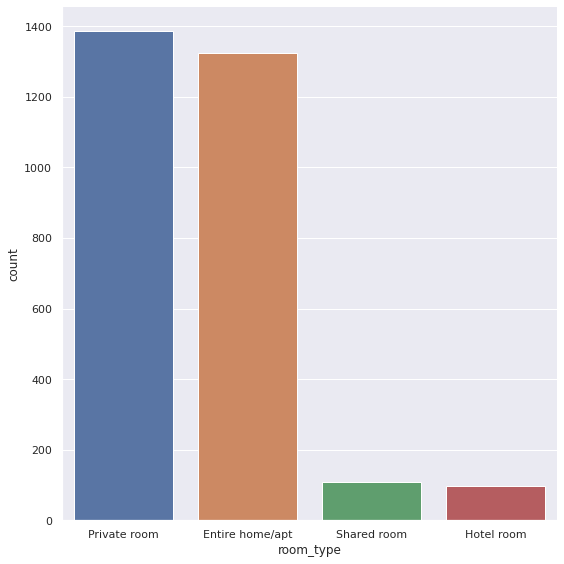

In [35]:
sb.catplot(x = "room_type", data = airbnb_df, kind = "count", height = 8)

Comparing the room types in relation to the price.

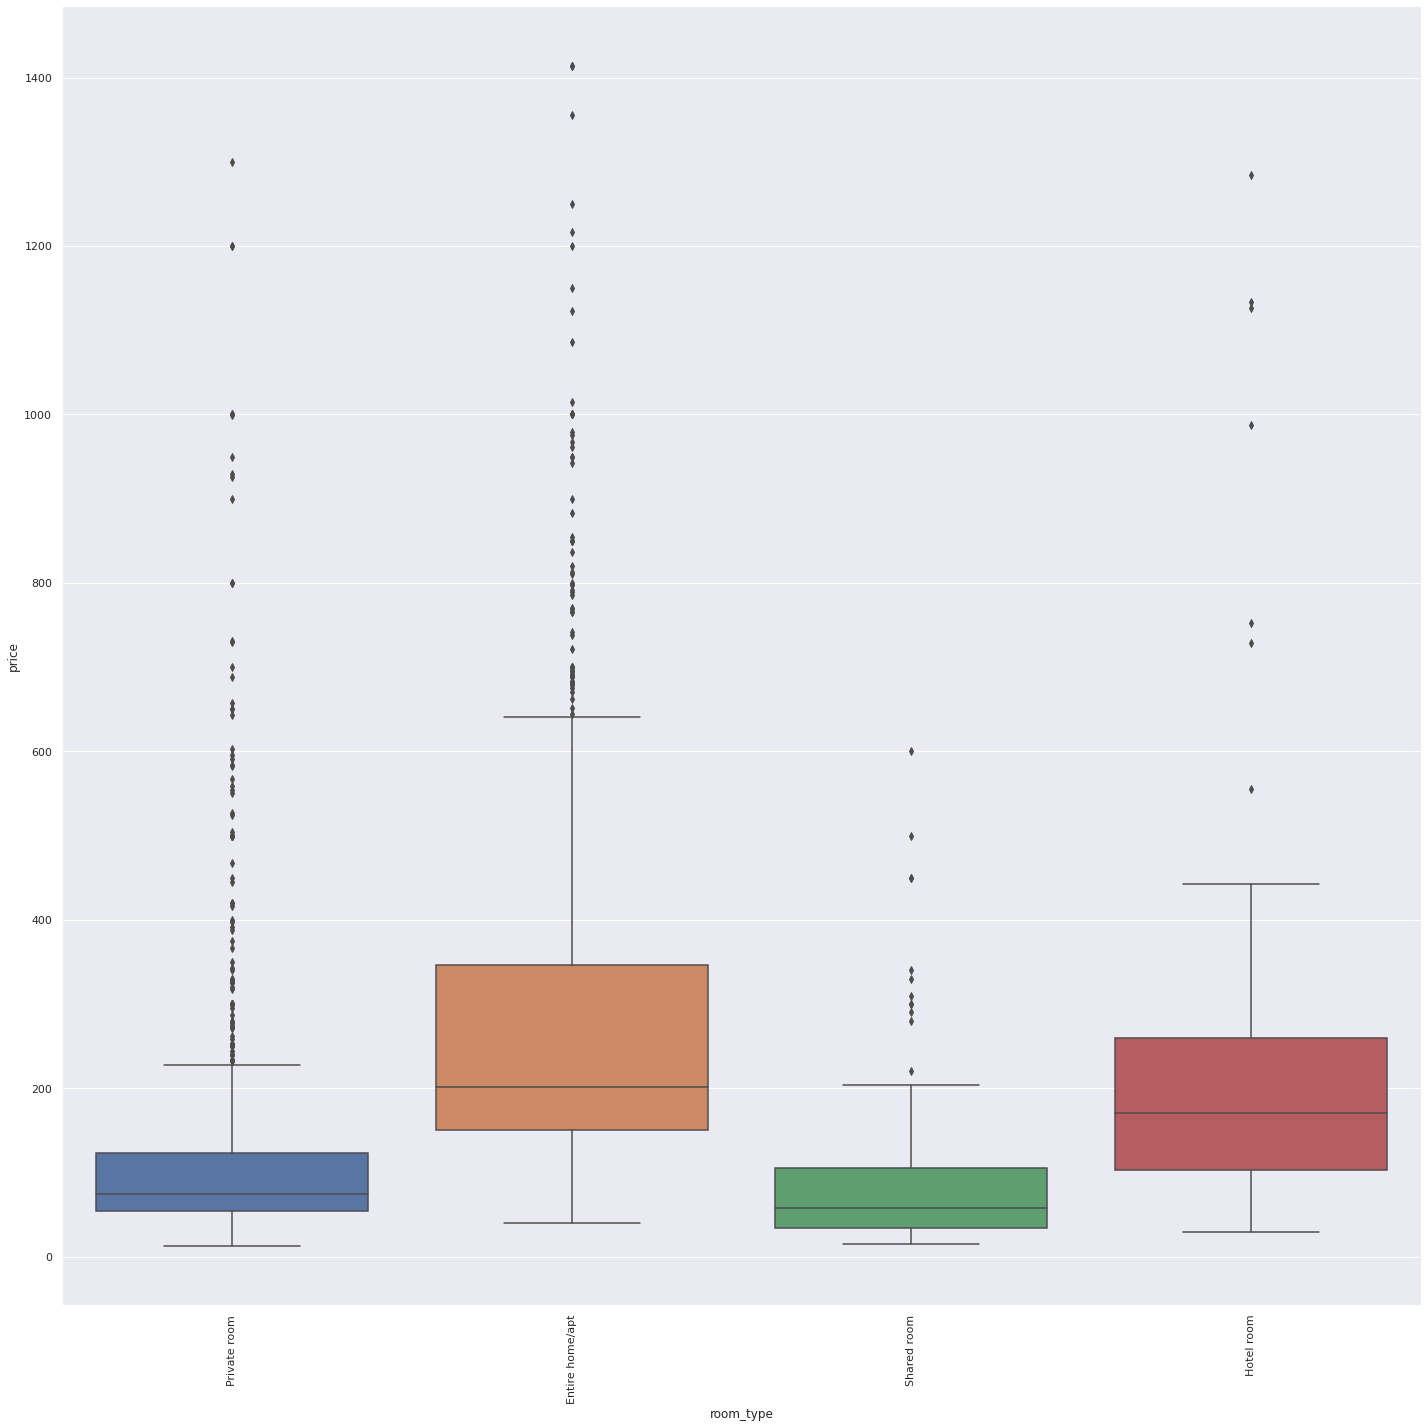

In [36]:
ax = sb.catplot(x="room_type", y="price", kind="box",legend=True, data=airbnb_df,height=20)
ax.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

It can be observed that the different room types vary in pricing with Entire home/apt having the highest median and shared room having the lowest median which makes sense.  

### Accommodates Variable


Table that shows the distribution of number of people Airbnbs can accommodate.

In [37]:
airbnb_df['accommodates'].describe()

count    2915.000000
mean        2.722127
std         1.697319
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        10.000000
Name: accommodates, dtype: float64

Visualise the data using boxplot.

In [38]:
f = plt.figure(figsize=(12, 6))
sb.boxplot(data = airbnb_df['accommodates'], orient = "h")

Comparing the number of people accommodated to the price.

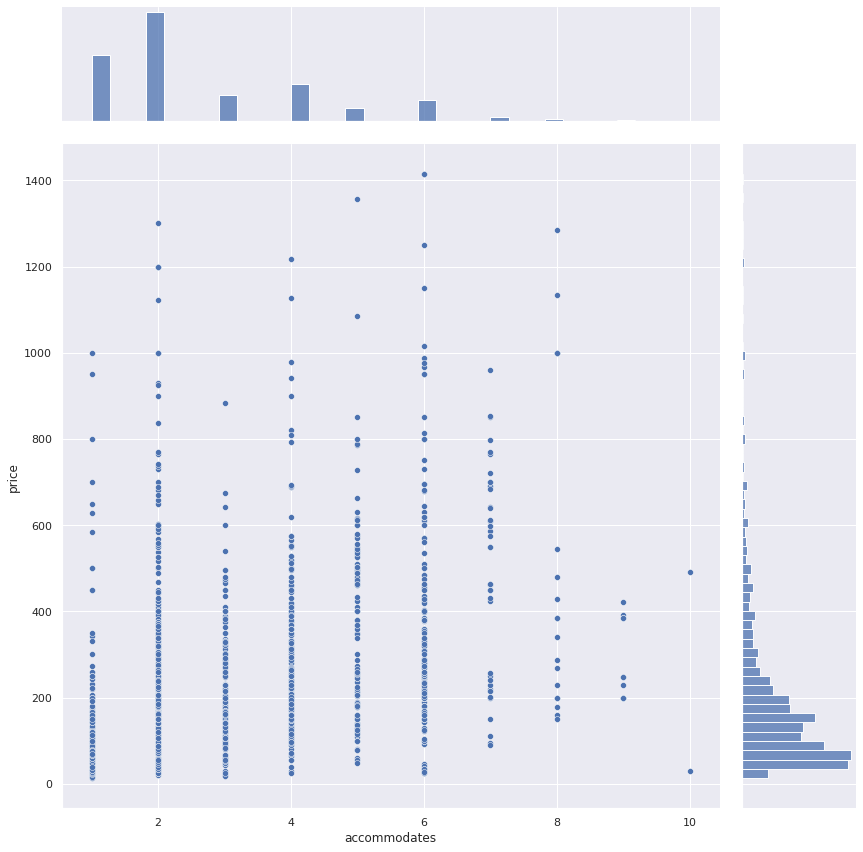

In [39]:
sb.jointplot(data = airbnb_df, x="accommodates", y="price", height=12)

### Bedrooms Variable


Table that shows the distribution of number of bedrooms in Airbnbs.

In [40]:
airbnb_df['bedrooms'].describe()

count    2915.000000
mean        1.315952
std         0.609355
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: bedrooms, dtype: float64

Visualise the data using boxplot.

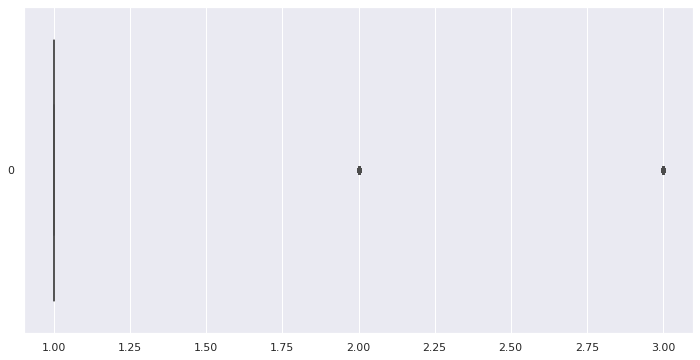

In [41]:
f = plt.figure(figsize=(12, 6))
sb.boxplot(data = airbnb_df['bedrooms'], orient = "h")

Comparing the number of bedrooms to the price.

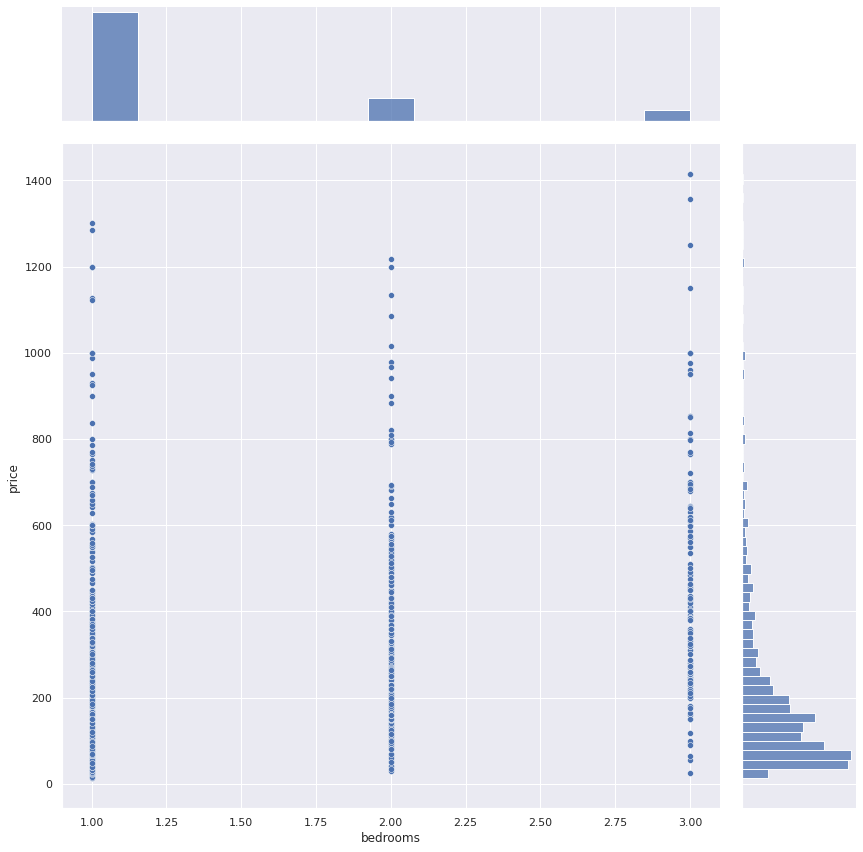

In [42]:
sb.jointplot(data = airbnb_df, x="bedrooms", y="price", height=12)

### Beds Variable


Table that shows the distribution of number of beds in Airbnbs.

In [43]:
airbnb_df['beds'].describe()

count    2915.000000
mean        1.615094
std         1.015686
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: beds, dtype: float64

Visualise the data using boxplot.

In [44]:
f = plt.figure(figsize=(12, 6))
sb.boxplot(data = airbnb_df['beds'], orient = "h")

Comparing the number of beds to the price.

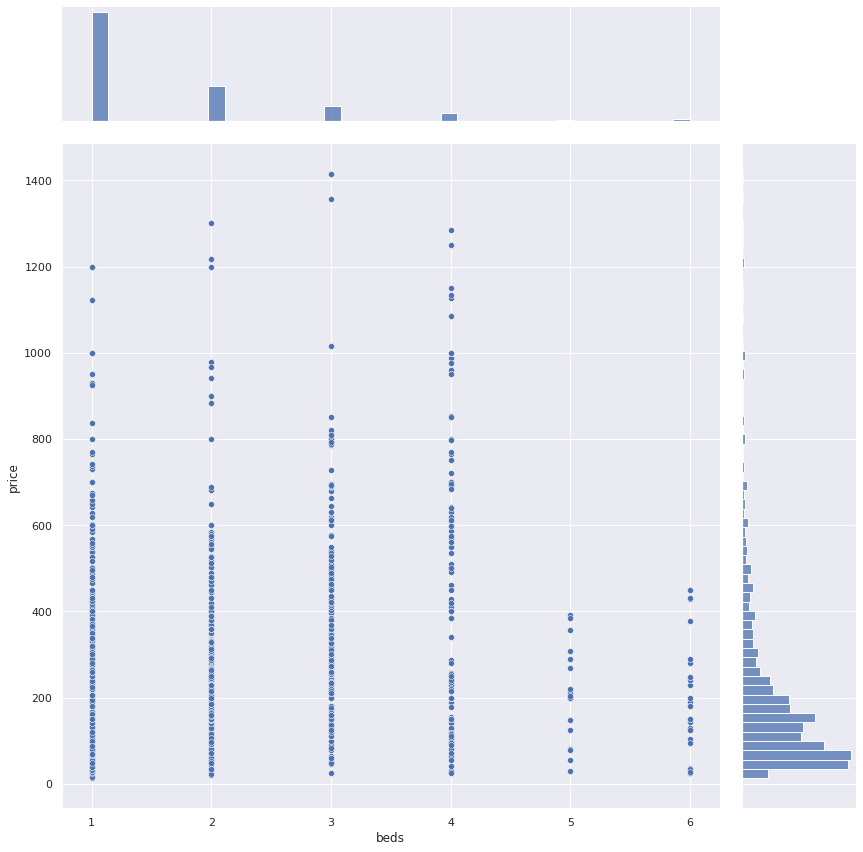

In [45]:
sb.jointplot(data = airbnb_df, x="beds", y="price", height=12)

### Minimum Nights Variable


Table that shows the distribution of minimum nights required to stay in Airbnbs.

In [46]:
airbnb_df['minimum_nights'].describe()

count    2915.000000
mean       38.038079
std        47.577141
min         1.000000
25%         3.000000
50%         7.000000
75%        90.000000
max       200.000000
Name: minimum_nights, dtype: float64

Visualise the data using boxplot.

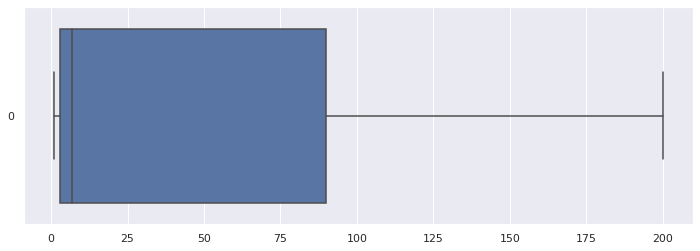

In [47]:
f = plt.figure(figsize=(12, 4))
sb.boxplot(data = airbnb_df['minimum_nights'], orient = "h")

Comparing the minimum nights to the price.

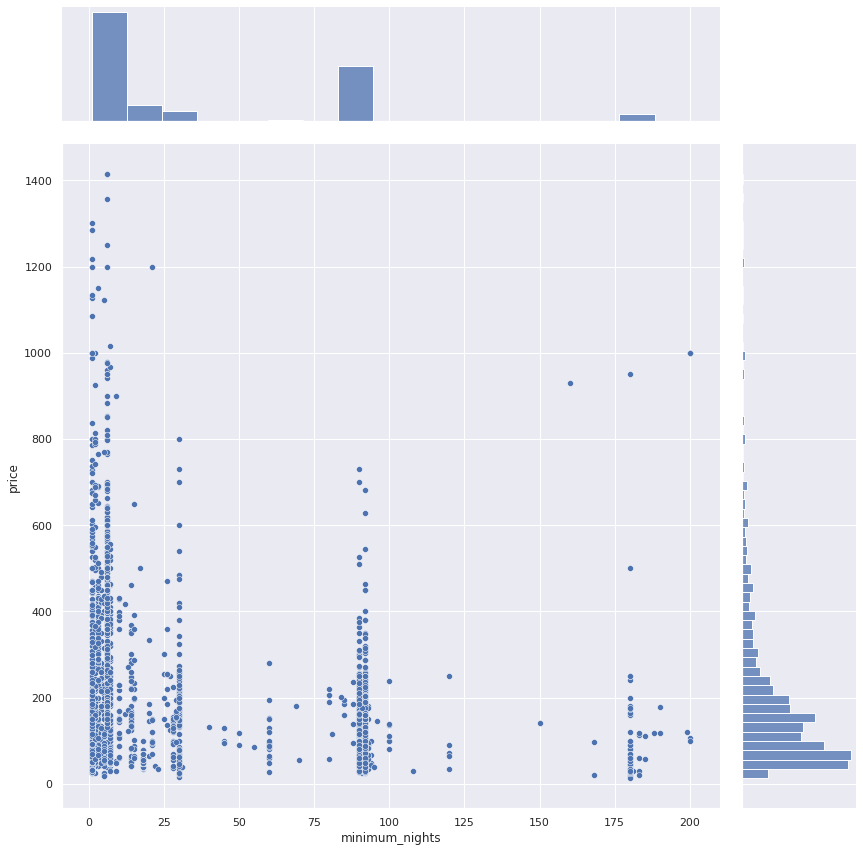

In [48]:
sb.jointplot(data = airbnb_df, x="minimum_nights", y="price", height=12)

### Availability 365 Variable

Table that shows the distribution of the number of days the Airbnbs are available in a year.

In [49]:
airbnb_df['availability_365'].describe()

count    2915.000000
mean      225.935506
std       145.535586
min         0.000000
25%        83.000000
50%       312.000000
75%       361.000000
max       365.000000
Name: availability_365, dtype: float64

Visualise the data using boxplot.

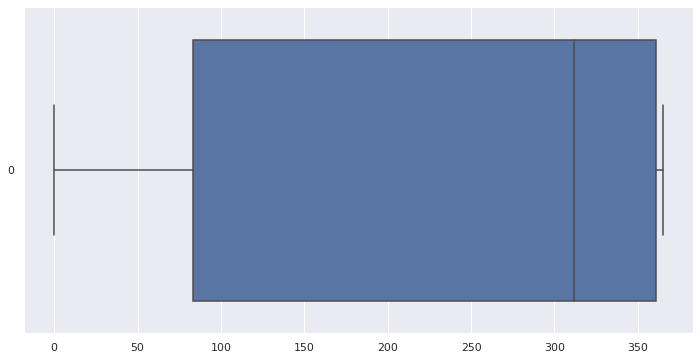

In [50]:
f = plt.figure(figsize=(12, 6))
sb.boxplot(data = airbnb_df['availability_365'], orient = "h")

Comparing the availability every year to the price.

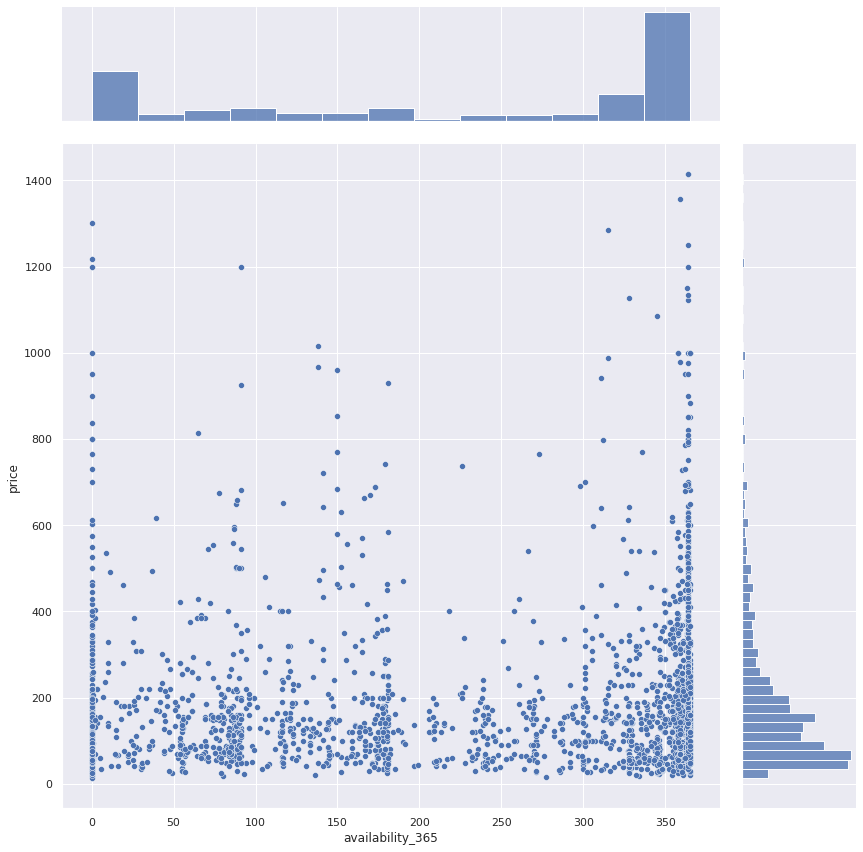

In [51]:
sb.jointplot(data = airbnb_df, x="availability_365", y="price", height=12)

### Number of Reviews Variable


Table that shows the distribution of number of reviews for Airbnbs.

In [52]:
airbnb_df['number_of_reviews'].describe()

count    2915.000000
mean        8.078902
std        17.833515
min         0.000000
25%         0.000000
50%         1.000000
75%         6.000000
max       110.000000
Name: number_of_reviews, dtype: float64

Visualise the data using boxplot.

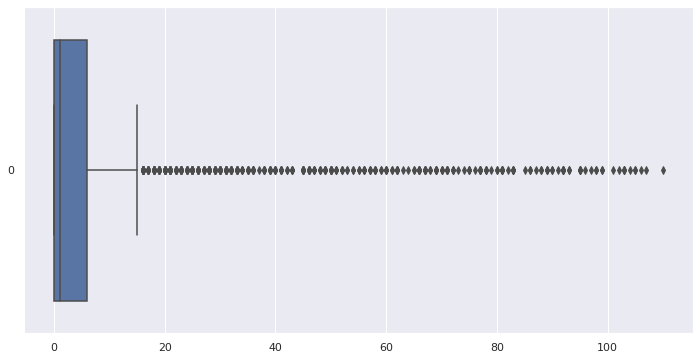

In [53]:
f = plt.figure(figsize=(12, 6))
sb.boxplot(data = airbnb_df['number_of_reviews'], orient = "h")

Comparing the number of reviews to the price.

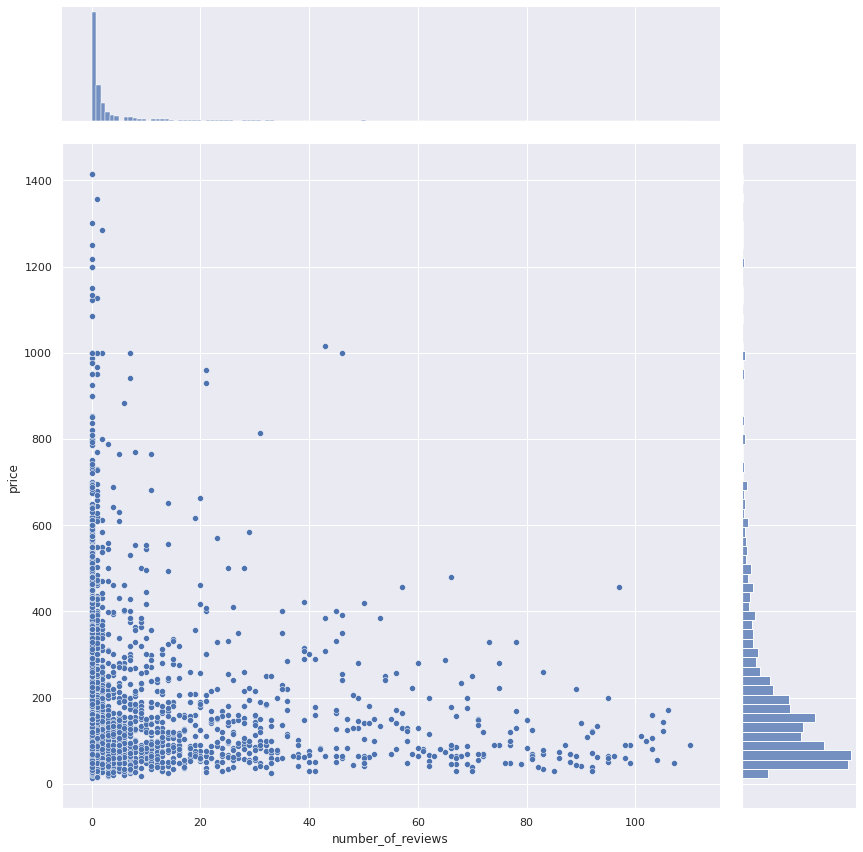

In [54]:
sb.jointplot(data = airbnb_df, x="number_of_reviews", y="price", height=12)

### Calculated Host Listings Count Variable


Table that shows the distribution of number of listings by the host of Airbnbs.

In [55]:
airbnb_df['calculated_host_listings_count'].describe()

count    2915.000000
mean       45.755746
std        63.012293
min         1.000000
25%         2.000000
50%        10.000000
75%        65.000000
max       199.000000
Name: calculated_host_listings_count, dtype: float64

Visualise the data using boxplot.

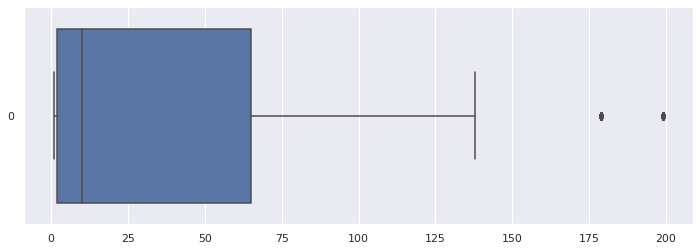

In [56]:
f = plt.figure(figsize=(12, 4))
sb.boxplot(data = airbnb_df['calculated_host_listings_count'], orient = "h")

Comparing the calculated host listings count to the price.

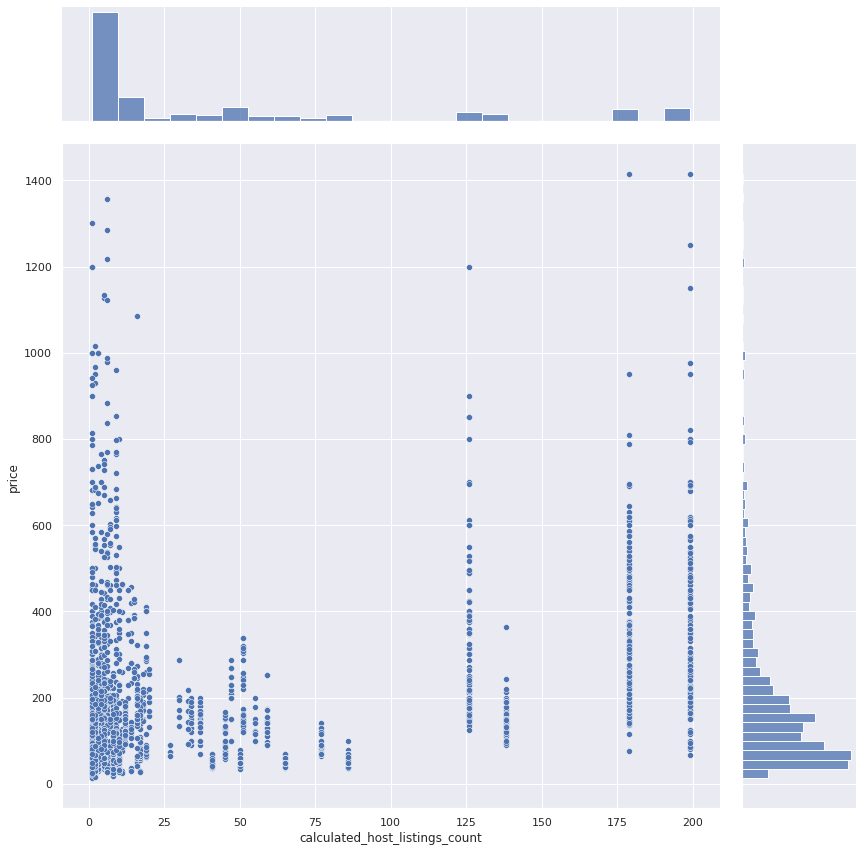

In [57]:
sb.jointplot(data = airbnb_df, x="calculated_host_listings_count", y="price", height=12)

## Correlation Analysis



Taking a look at the correlation matrix for numeric data below reveals that accomodates, bedrooms and beds have the highest correlation to price.

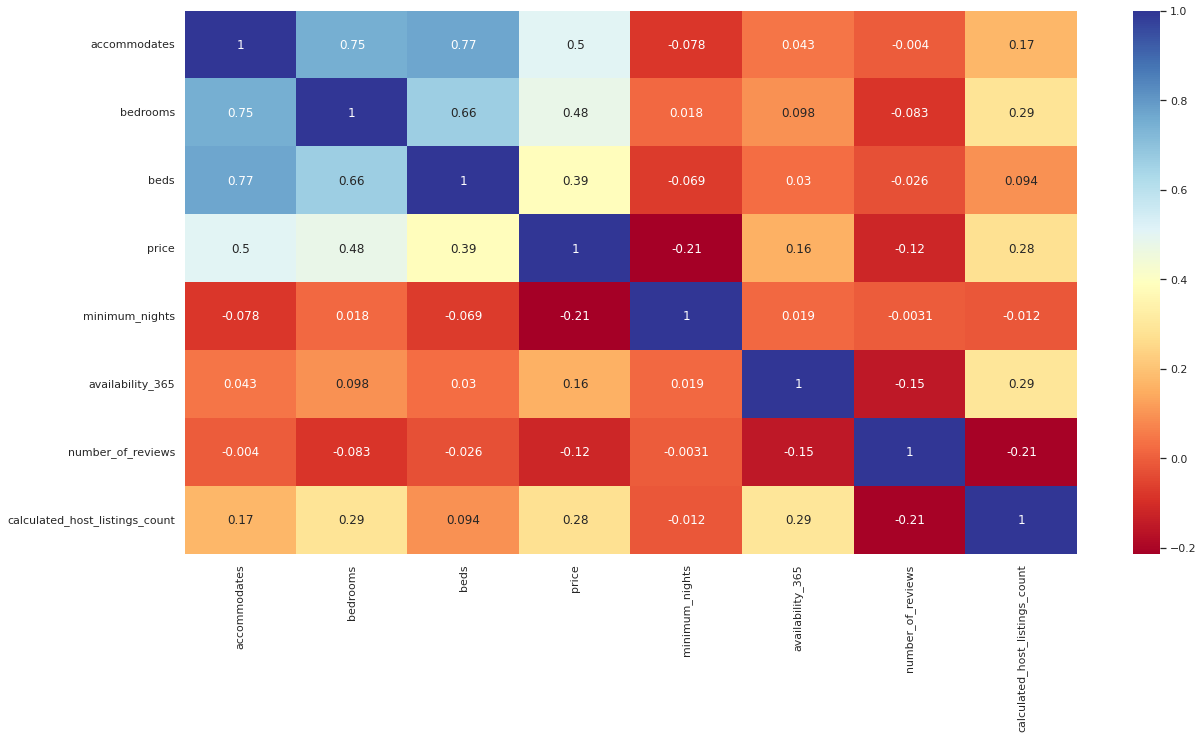

In [58]:
plt.figure(figsize=(20,10))
sb.heatmap(airbnb_df.corr(),cmap="RdYlBu",annot=True)

Correlation matrix with new variables distance to nearest tourist attraction and average distance from tourist attractions by combining Airbnb and Tourist Attractions dataset.

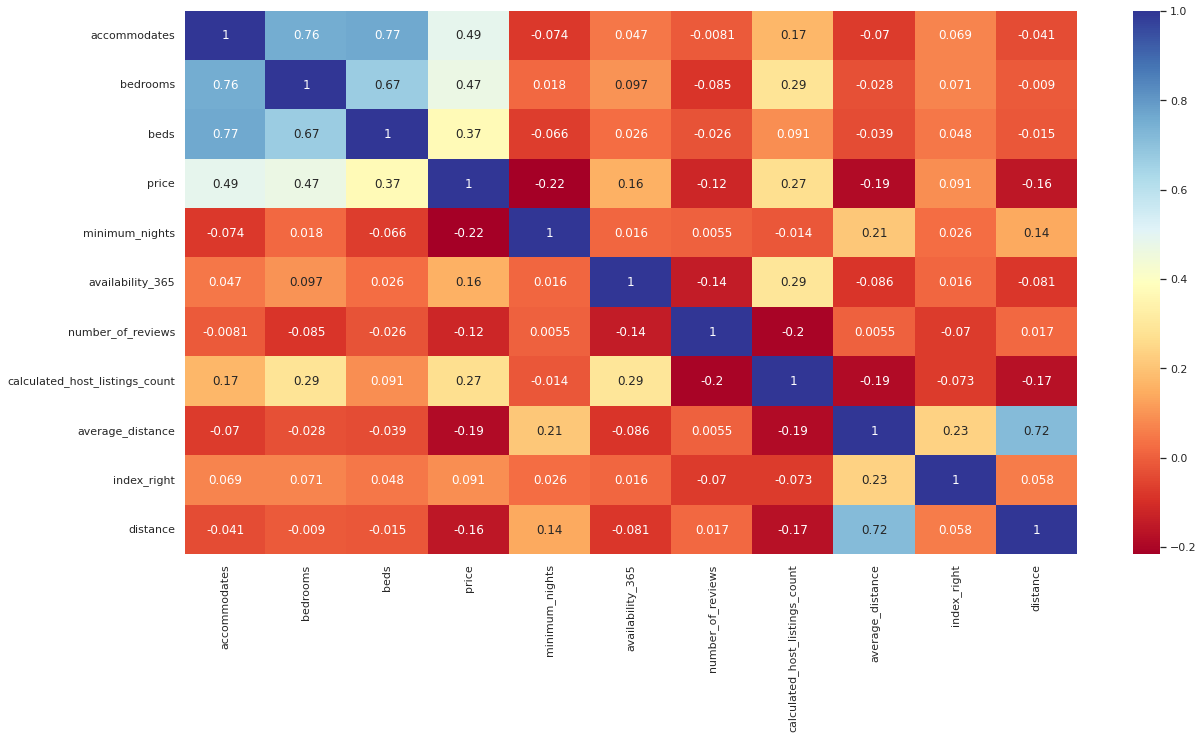

In [59]:
tourism_df = tourism_df.to_crs(epsg=32643)
airbnb_df = airbnb_df.to_crs(epsg=32643)

average = [tourism_df.geometry.distance(airbnb_df.iloc[i].geometry).mean() for i in range(len(airbnb_df))]
airbnb_df["average_distance"] = average

combined = gp.sjoin_nearest(airbnb_df, tourism_df, distance_col="distance")
plt.figure(figsize=(20,10))
sb.heatmap(combined.corr(),cmap="RdYlBu",annot=True)

Both distance variables do have a negative relationship but only a weak one.

# Machine Learning


### One-Hot Encoding 

One-hot encoding is done on categorical variables to be used in machine learning models.

In [60]:
from sklearn.preprocessing import OneHotEncoder
#creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
#perform one-hot encoding on column 
enc_df1 = pd.DataFrame(enc.fit_transform(combined[['neighbourhood_cleansed']]).toarray())
enc_df1.columns = enc.get_feature_names_out()
enc_df2 = pd.DataFrame(enc.fit_transform(combined[['neighbourhood_group_cleansed']]).toarray())
enc_df2.columns = enc.get_feature_names_out()
enc_df3 = pd.DataFrame(enc.fit_transform(combined[['property_type']]).toarray())
enc_df3.columns = enc.get_feature_names_out()
enc_df4 = pd.DataFrame(enc.fit_transform(combined[['room_type']]).toarray())
enc_df4.columns = enc.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
#combined = pd.merge(combined, enc_df1, left_index=True, right_index=True, how='inner')
#combined = pd.merge(combined, enc_df2, left_index=True, right_index=True, how='inner')
#combined = pd.merge(combined, enc_df3, left_index=True, right_index=True, how='inner')
#combined = pd.merge(combined, enc_df4, left_index=True, right_index=True, how='inner')

#view final df
enc_df1.info()
enc_df2.info()
enc_df3.info()
enc_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 42 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   neighbourhood_cleansed_Ang Mo Kio               3035 non-null   float64
 1   neighbourhood_cleansed_Bedok                    3035 non-null   float64
 2   neighbourhood_cleansed_Bishan                   3035 non-null   float64
 3   neighbourhood_cleansed_Bukit Batok              3035 non-null   float64
 4   neighbourhood_cleansed_Bukit Merah              3035 non-null   float64
 5   neighbourhood_cleansed_Bukit Panjang            3035 non-null   float64
 6   neighbourhood_cleansed_Bukit Timah              3035 non-null   float64
 7   neighbourhood_cleansed_Central Water Catchment  3035 non-null   float64
 8   neighbourhood_cleansed_Choa Chu Kang            3035 non-null   float64
 9   neighbourhood_cleansed_Clementi          

In [61]:
combined.head()

neighbourhood_cleansed neighbourhood_group_cleansed  \
0              Bukit Timah               Central Region   
49             Bukit Batok                  West Region   
218            Bukit Timah               Central Region   
234          Choa Chu Kang                  West Region   
328            Bukit Batok                  West Region   

                   property_type        room_type  accommodates  bedrooms  \
0    Private room in rental unit     Private room             2       1.0   
49   Private room in rental unit     Private room             1       1.0   
218  Private room in rental unit     Private room             1       1.0   
234           Entire rental unit  Entire home/apt             6       3.0   
328           Entire rental unit  Entire home/apt             4       3.0   

     beds  price  minimum_nights  availability_365  number_of_reviews  \
0     1.0   80.0              90               365                 18   
49    1.0   80.0              14                 0                  0   
218   1.0   77.0              90               365                  2   
234   4.0  233.0               2               357                  9   
328   3.0  150.0              90               147                 55   

     calculated_host_listings_count                        geometry  \
0                                 1  POINT (3847013.492 168438.722)   
49                                1  POINT (3843789.851 169273.328)   
218                               1  POINT (3844814.982 169767.432)   
234                               1  POINT (3843667.222 174093.016)   
328                               1  POINT (3843433.309 170716.352)   

     average_distance  index_right  \
0        10385.865683           41   
49       12941.581250           41   
218      12423.374487           41   
234      15520.181421           41   
328      13823.539478           41   

                                                  Name  \
0    www.yoursingapore.com/en/see-do-singapore/hist...   
49   www.yoursingapore.com/en/see-do-singapore/hist...   
218  www.yoursingapore.com/en/see-do-singapore/hist...   
234  www.yoursingapore.com/en/see-do-singapore/hist...   
328  www.yoursingapore.com/en/see-do-singapore/hist...   

                                           Description     distance  
0    <html xmlns:fo="http://www.w3.org/1999/XSL/For...  3080.916776  
49   <html xmlns:fo="http://www.w3.org/1999/XSL/For...  1797.021455  
218  <html xmlns:fo="http://www.w3.org/1999/XSL/For...   920.522133  
234  <html xmlns:fo="http://www.w3.org/1999/XSL/For...  3626.544778  
328  <html xmlns:fo="http://www.w3.org/1999/XSL/For...  1470.530967

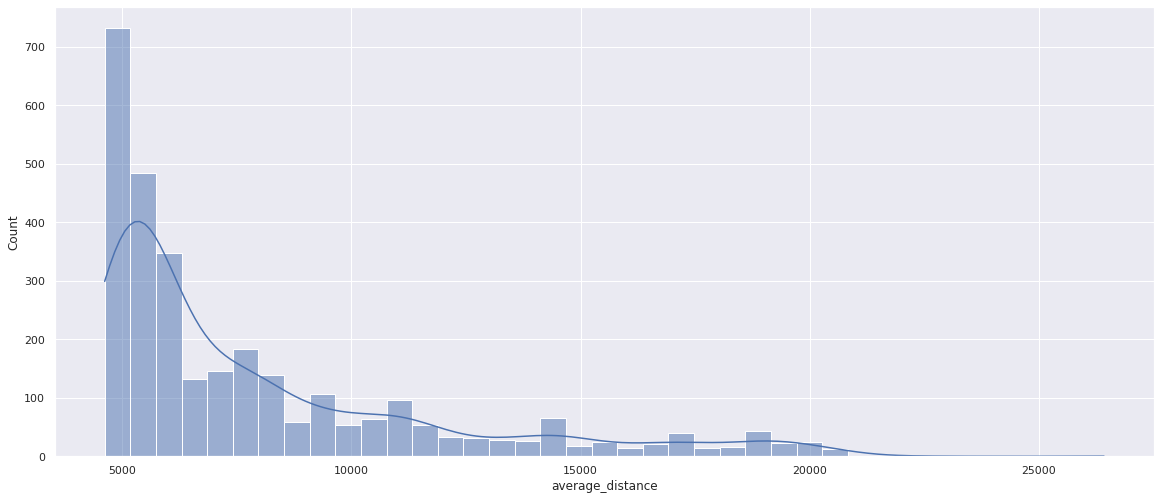

In [62]:
sb.histplot(data=combined['average_distance'],kde = True)

## Machine Learning: linear regression

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [64]:
def univariateLinearRegression(Xvar = None, yvar = None, df = None, title = None):
    '''
        Function to perform Linear Regression with Xvar and yvar in df.
        Prints the required plots within the function. Returns nothing.
    '''    
    # Extract Response and Predictors
    if isinstance(Xvar, str):
      X = pd.DataFrame(df[Xvar])
    else:
      X = Xvar
    if isinstance(yvar, str):
      y = pd.DataFrame(df[yvar])
    else:
      y = yvar
    #y = pd.DataFrame(df[yvar])
    #X = pd.DataFrame(df[Xvar])

    # Split the Dataset into random Train and Test (80:20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model

    # Print the coefficients of the Regression Line
    print('Intercept \t: b = ', linreg.intercept_)
    print('Coefficients \t: a = ', linreg.coef_)

    # Formula for the Regression line
    regline_x = X_train
    regline_y = linreg.intercept_ + linreg.coef_ * X_train
    
    # Predict Response corresponding to Predictors
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)

    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(12, 12))
    axes[0].scatter(y_train, y_train_pred, color = "blue")
    axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
    axes[0].set_xlabel("True values of the Response Variable (Train)")
    axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
    axes[1].scatter(y_test, y_test_pred, color = "green")
    axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
    axes[1].set_xlabel("True values of the Response Variable (Test)")
    axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
    
    # Check the Goodness of Fit (on Train Data)
    if title is None:
      print('\033[1m' + Xvar + '\033[0m')
    else:
      print('\033[1m' + title + '\033[0m')
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Prediction Accuracy of Model \tTest Dataset")
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()
    return mean_squared_error(y_test, y_test_pred, squared=False)
    '''
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(12, 12))
    axes[0].scatter(X_train, y_train, color = "blue")
    axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)
    axes[0].set_title("Regression Line on Train Set")
    axes[1].scatter(X_test, y_test, color = "green")
    axes[1].scatter(X_test, y_test_pred, color = "red")
    axes[1].set_title("Model Prediction on Test Set")
    plt.show()
    '''

In [65]:
TESTVARIABLES2=combined.columns

unwanted = {'price','geometry','index_right','neighbourhood_cleansed', 'neighbourhood_group_cleansed','property_type','room_type','Name','Description'}
TESTVARIABLES2 = [e for e in TESTVARIABLES2 if e not in unwanted]
TESTVARIABLES2
#TESTVARIABLES=['room_type','property_type','neighbourhood_cleansed','accommodates','bedrooms','beds','minimum_nights','availability_365','number_of_reviews','calculated_host_listings_count']
TESTVARIABLES=['accommodates','bedrooms','beds','minimum_nights','availability_365','number_of_reviews','calculated_host_listings_count','average_distance']
TESTVARIABLES_ONE_HOT = {
    "neighbourhood_cleansed": enc_df1.columns.values,
    'neighbourhood_group_cleansed': enc_df2.columns.values,
    'property_type': enc_df3.columns.values,
    'room_type': enc_df4.columns.values
}


Intercept 	: b =  [46.4945271]
Coefficients 	: a =  [[51.47710535]]
accommodates
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.24546098910238345
Mean Squared Error (MSE) 	: 23912.70304938957

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 26998.30681316779

Intercept 	: b =  [-0.09113311]
Coefficients 	: a =  [[143.58108562]]
bedrooms
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2327775356732047
Mean Squared Error (MSE) 	: 25094.460587125763

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 25492.001947199602

Intercept 	: b =  [84.97172129]
Coefficients 	: a =  [[62.90724042]]
beds
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.13096739380348388
Mean Squared Error (MSE) 	: 27057.47430393059

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 30943.39826382553

Intercept 	: b =  [223.44361585]
Coefficients 	: a =  [[-0.91203011]]
minimum_nights
Goodn

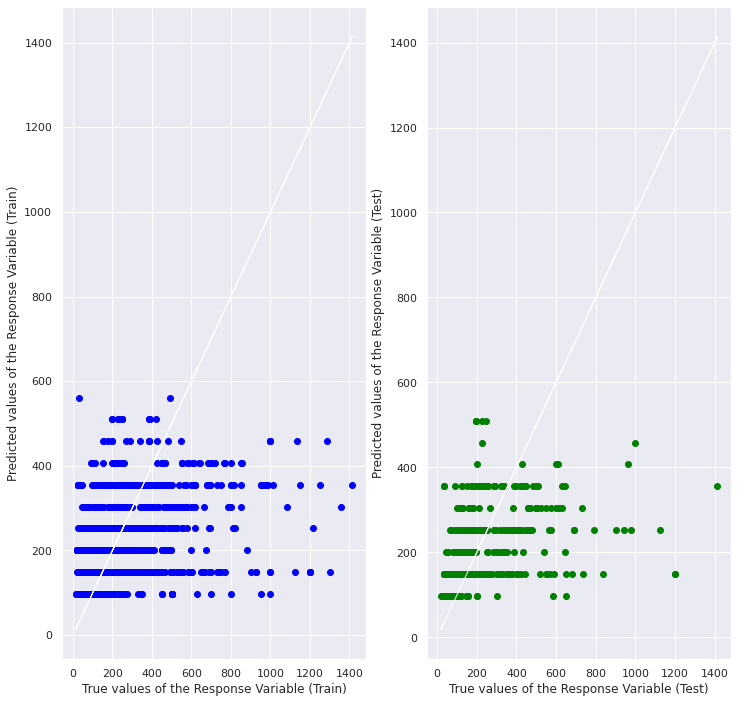

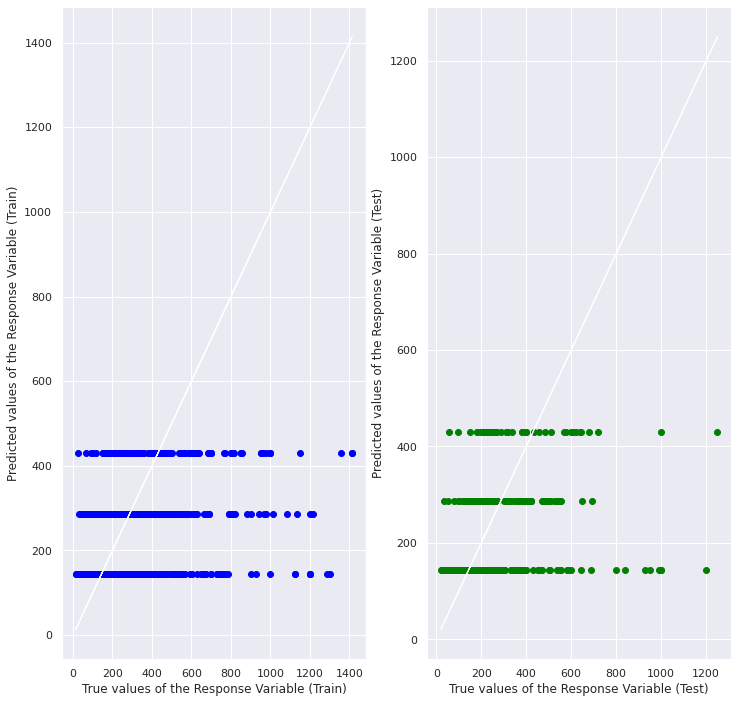

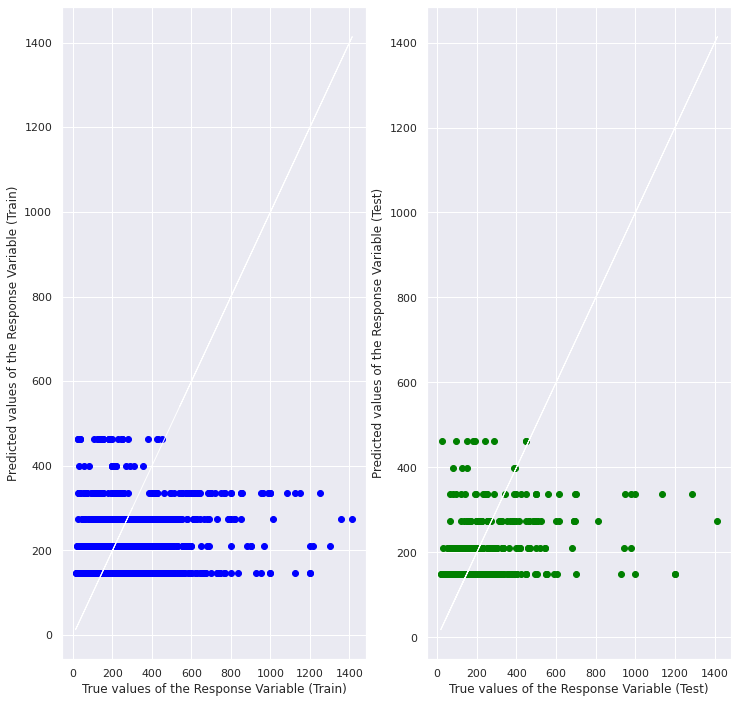

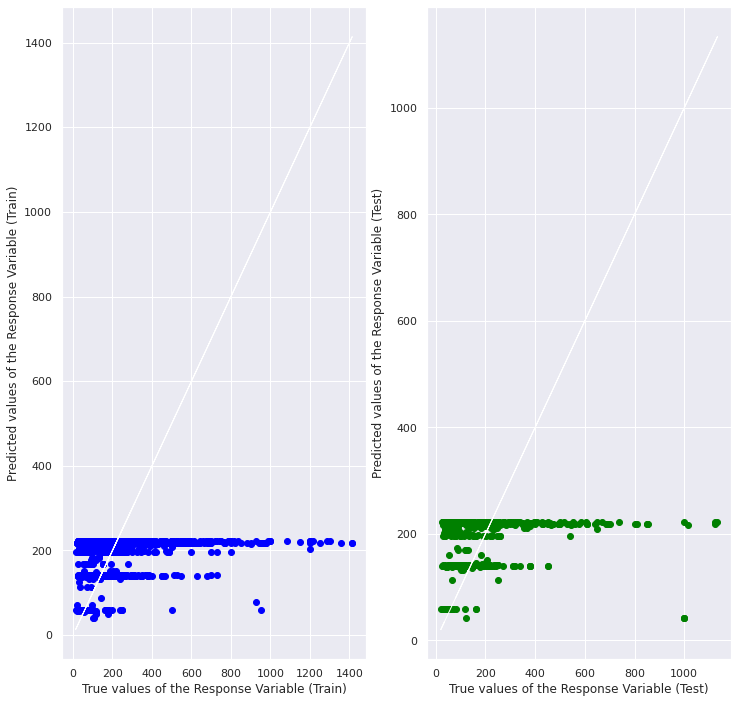

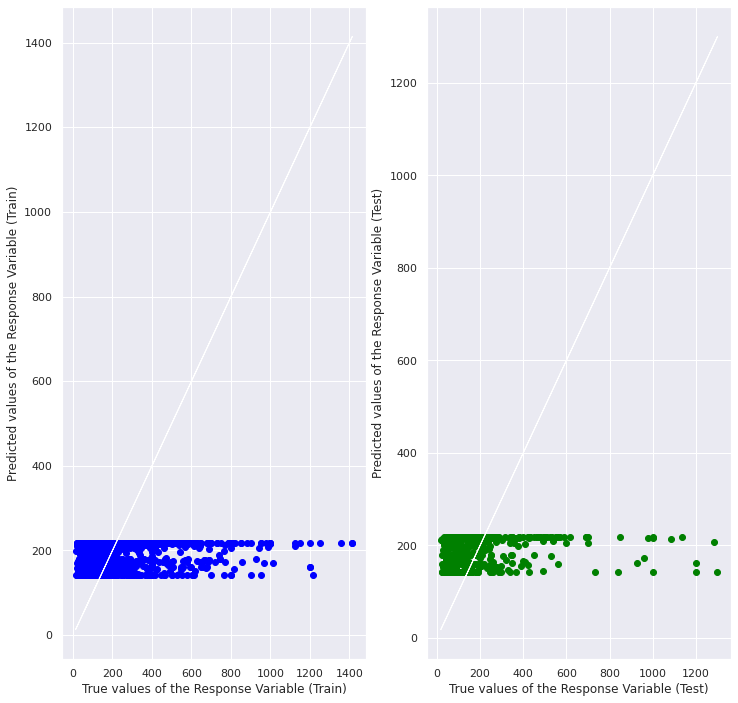

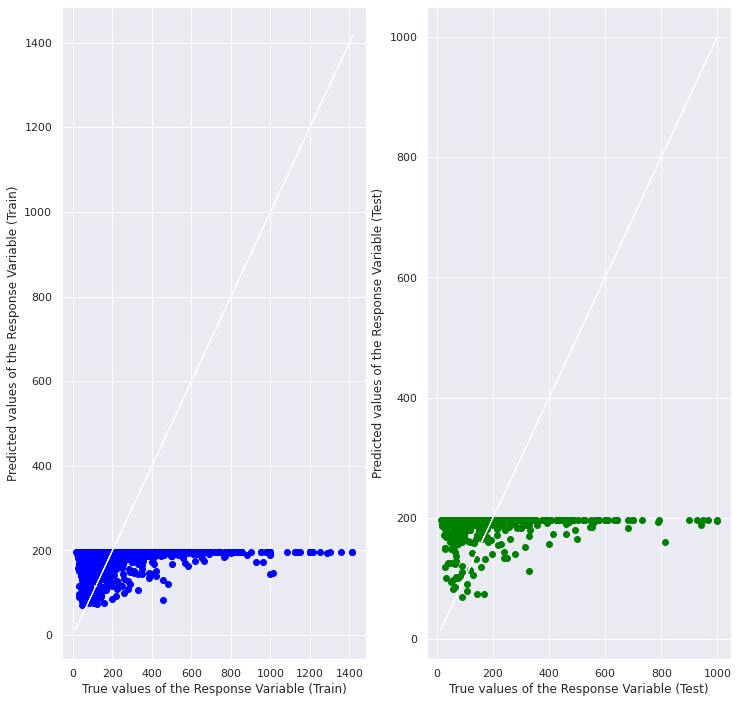

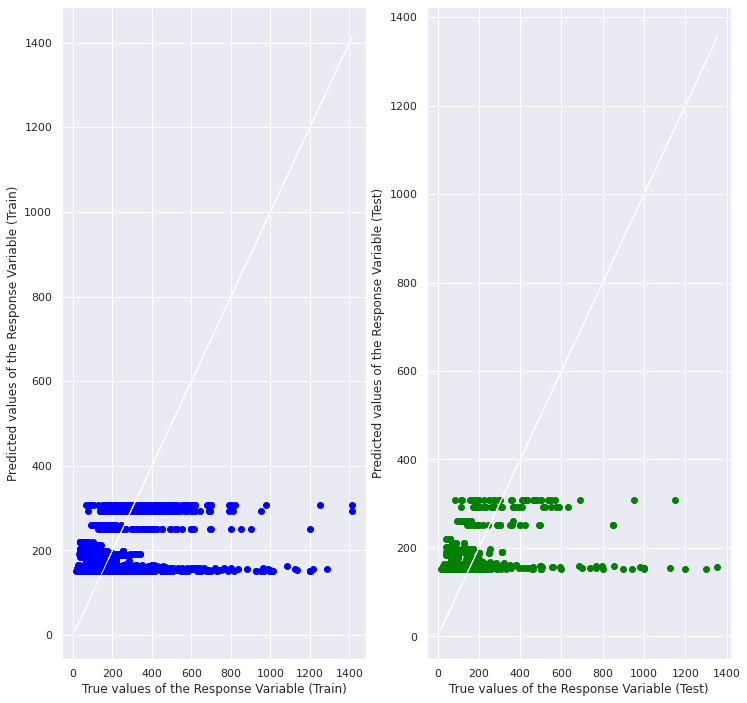

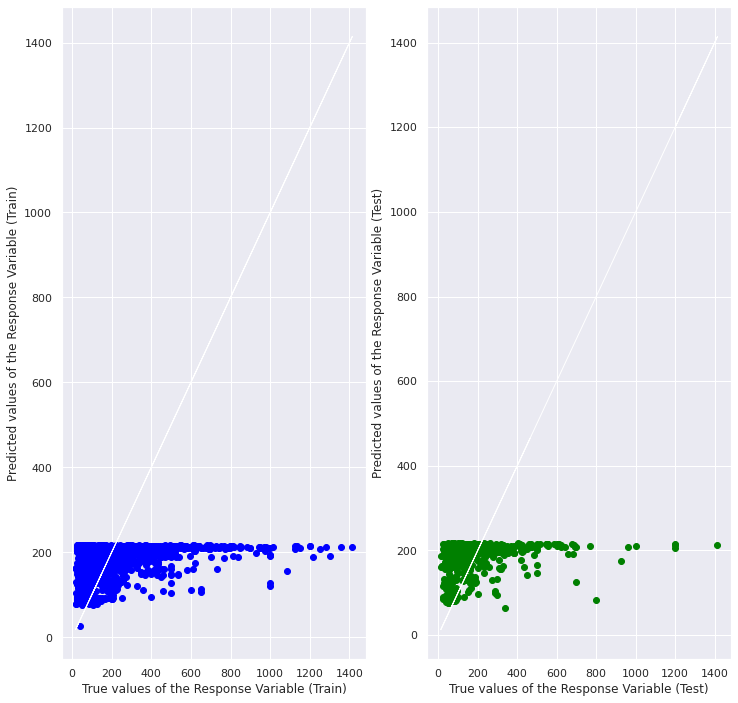

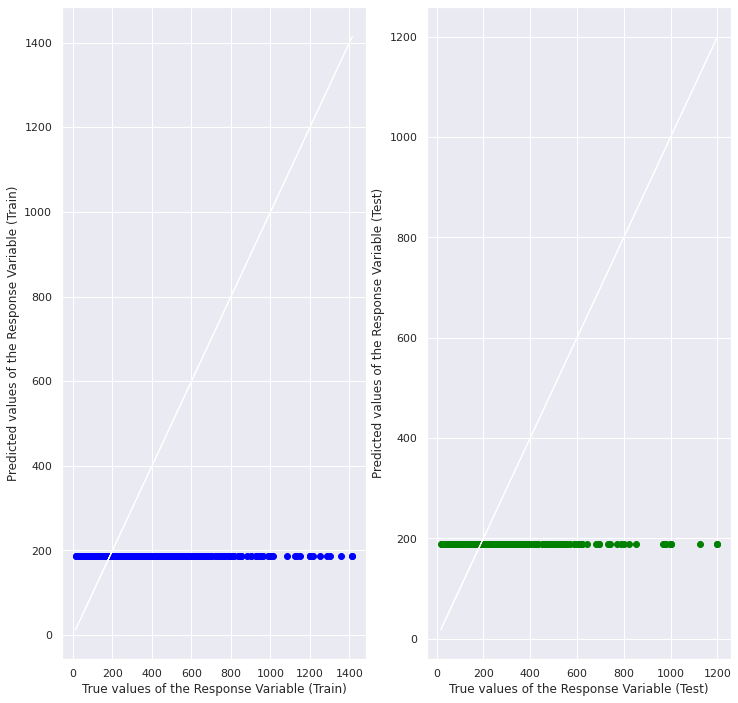

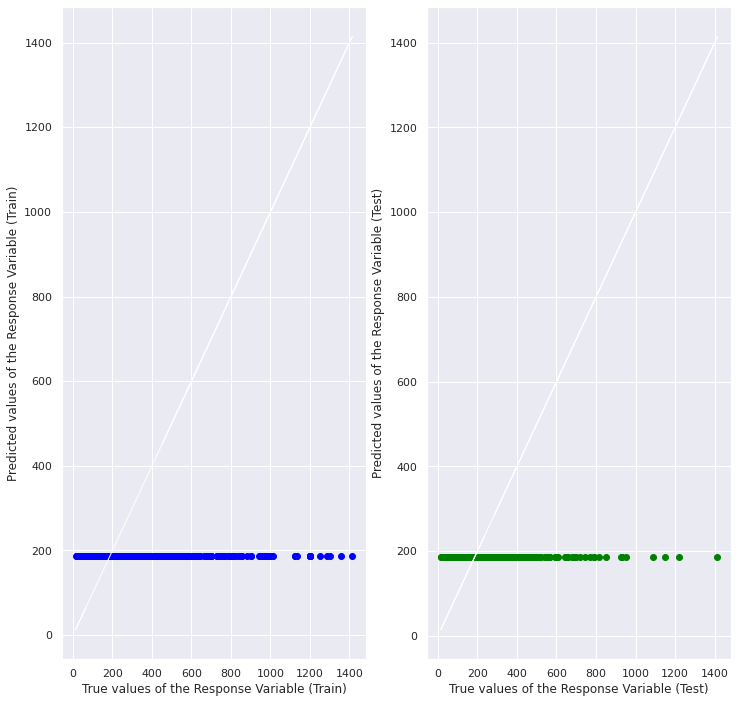

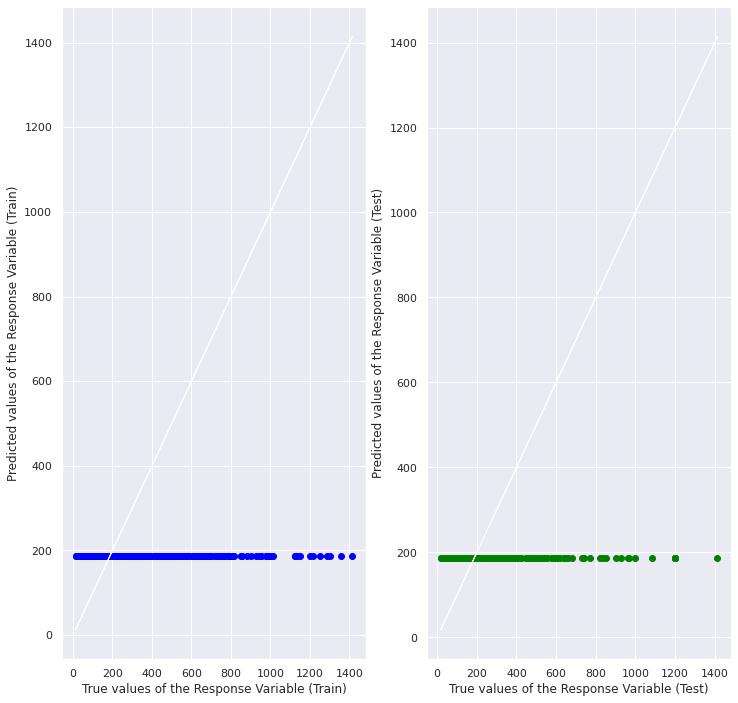

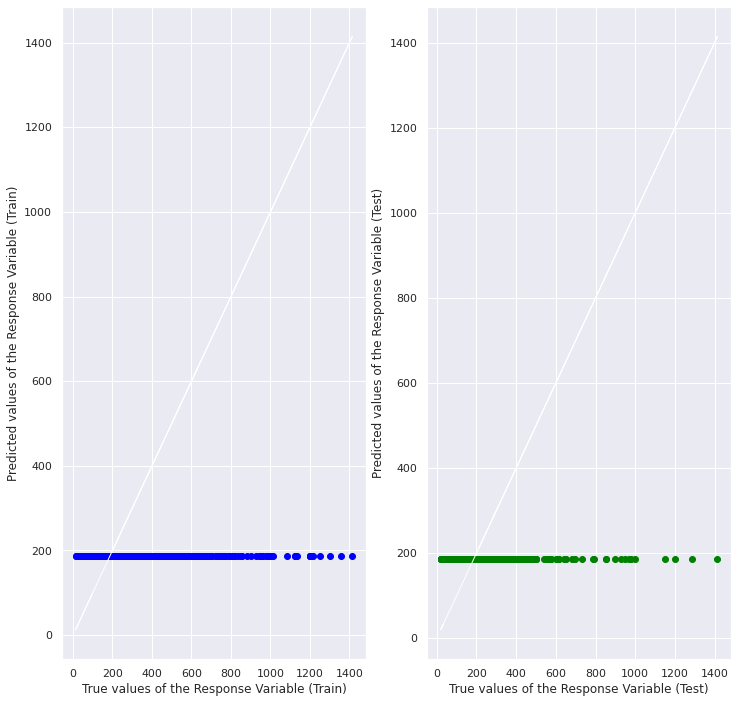

In [66]:
result={}
for x in TESTVARIABLES:
    #tbappend = (univariateLinearRegression(Xvar = x, yvar = "price", df = combined)+univariateLinearRegression(Xvar = x, yvar = "price", df = combined)+univariateLinearRegression(Xvar = x, yvar = "price", df = combined))/3
    tbappend = univariateLinearRegression(Xvar = x, yvar = "price", df = combined)
    result[x]=tbappend

print()
print("Running Linear Regression on One Hot Variables!")

for key, value in TESTVARIABLES_ONE_HOT.items():
  enc = OneHotEncoder(sparse=False)
  X_transform = enc.fit_transform(gp.GeoDataFrame(combined, columns = value))
  #print(len(X_transform.shape))

  tbappend = univariateLinearRegression(Xvar = X_transform, yvar = "price", df = combined, title = key)
  result[key]=tbappend
  '''
  X_train, X_test, y_train, y_test = train_test_split(X_transform, combined["price"], test_size = 0.2)

  linreg = LinearRegression(fit_intercept=False)
  linreg.fit(X_train, y_train)

  result[key] = linreg.score(X_train, y_train)
  '''


In [67]:
result

{'accommodates': 164.31161496731687,
 'availability_365': 187.14421533880218,
 'average_distance': 174.3780274190521,
 'bedrooms': 159.6621493880112,
 'beds': 175.90735704860535,
 'calculated_host_listings_count': 187.88417699685604,
 'minimum_nights': 179.02007220437318,
 'neighbourhood_cleansed': 183.54574760444905,
 'neighbourhood_group_cleansed': 180.36985841082125,
 'number_of_reviews': 164.97037014996388,
 'property_type': 191.6885326269144,
 'room_type': 184.9449802737167}

Intercept 	: b =  [212.50867551]
Coefficients 	: a =  [[-0.02167725]]
distance
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.023421573225601344
Mean Squared Error (MSE) 	: 30611.631673579137

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 34823.360320675165



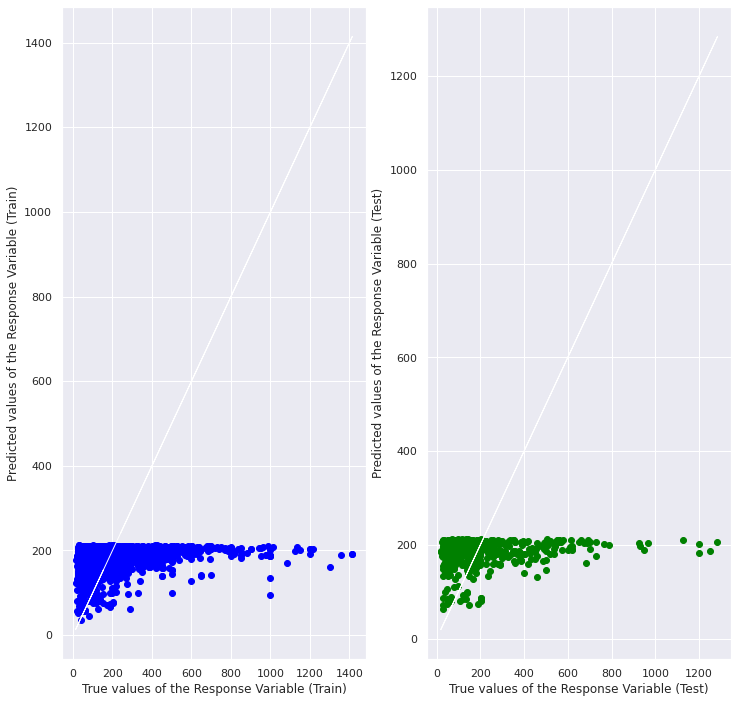

In [68]:
distResult = univariateLinearRegression(Xvar = "distance", yvar = "price", df = combined)

### Comparing the Linear regression model vs the added feature

In [69]:
result.pop('neighbourhood_cleansed')
result.pop('property_type')

191.6885326269144

Text(0.5, 0, 'Linear Regression RMSE')

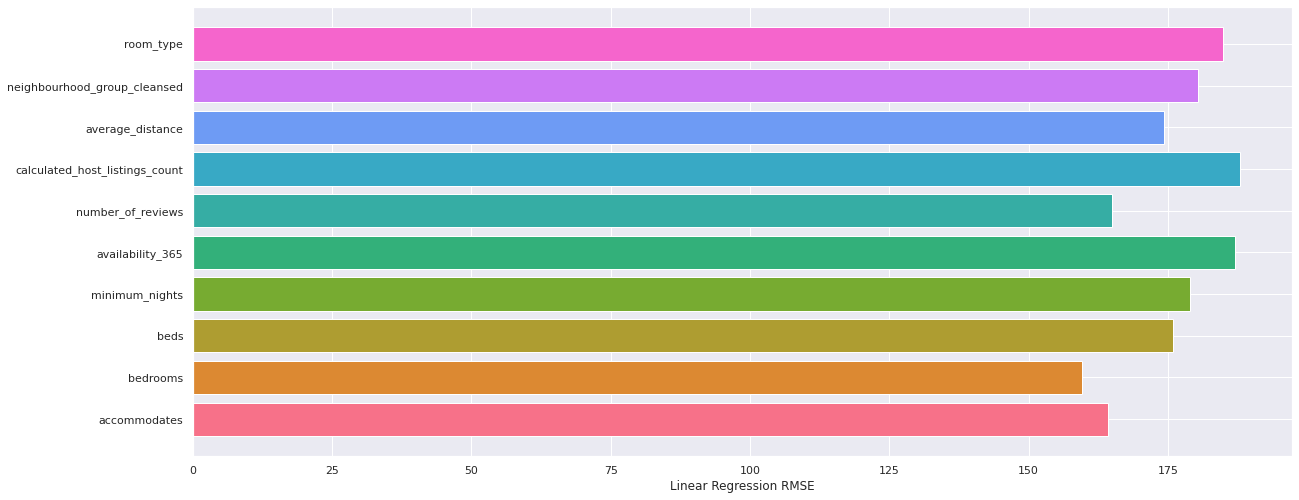

In [70]:

palette = sb.color_palette("husl", len(result))
ind = np.arange(len(result))
plt.barh(ind, list(result.values()), color=palette)
plt.yticks(ind, list(result.keys()))
plt.xlabel('Linear Regression RMSE')

## Initial Linear Regression Model
We select bedrooms, accomodates and calculated_host_listings_count as the variable for linear regression as it has the lowest MSE values. We believe that this is true in practice as well, as genereally more bedrooms and accomodates would lead to more living space, and thus increasing the value of the property.

In addition, we believe that calculated host listings count would affect price as generally, when the owner of alot of airbnbs rent out a place, they are more experienced in listings so they would value their airbnb higher.

([<matplotlib.axis.XTick at 0x7fdb505ed1d0>,
 [Text(0, 0, 'calculated_host_listings_count'),
  Text(0, 0, 'bedrooms'),
  Text(0, 0, 'accommodates'),
  Text(0, 0, 'distance'),
  Text(0, 0, 'average_distance')])

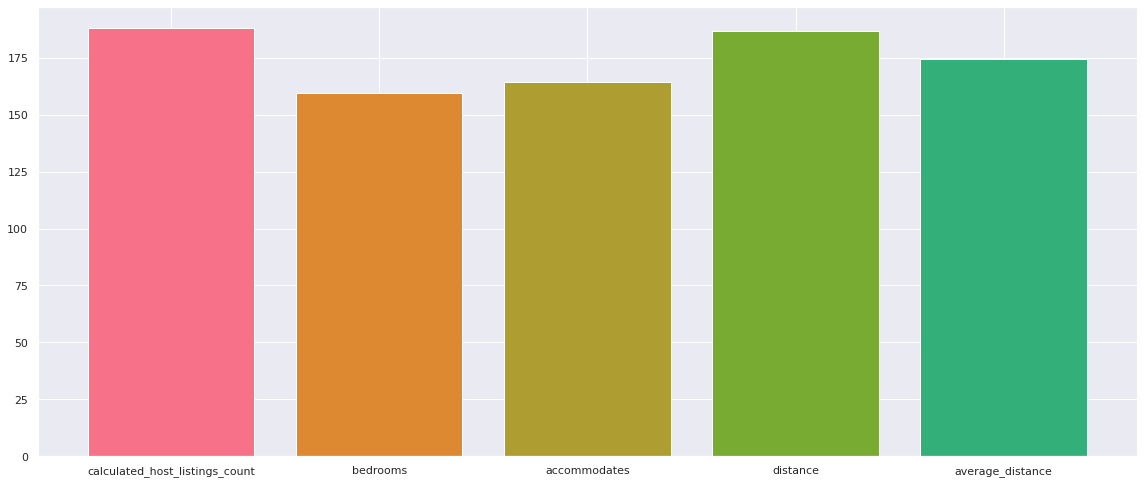

In [71]:
comparison={}
comparison['calculated_host_listings_count']=result['calculated_host_listings_count']
comparison['bedrooms']=result['bedrooms']
comparison['accommodates']=result['accommodates']
comparison['distance']=distResult
comparison['average_distance']=result['average_distance']
ind = np.arange(len(comparison))
plt.bar(ind, list(comparison.values()), color=palette)
plt.xticks(ind, list(comparison.keys()))

This shows that distance isnt as effective as bedrooms in being a good predictor for price

## Improvement on distances
We will apply different machine learning models to distances in order for it to be a more effective predictor of price

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import re
import xgboost as xgb

## Model: XGBoost
We'll try to use XGBoost to craft a better model of distances vs price, as XGBoost can be used directly for regression.

In [73]:

y = pd.DataFrame(combined['price'])
X = pd.DataFrame(combined['average_distance'])

# Split the Dataset into random Train and Test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#for multivar
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test  = sc.transform(X_test)
booster = xgb.XGBRegressor()
# In order to find best estimator for parameters during the search,
# create Grid
params = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
          'gamma': [0.0, 0.1, 0.2],
              'colsample_bytree': [0.6, 0.7, 1],
              }

# instantiate the tuned random forest
bgs = GridSearchCV(booster, params, cv=3, n_jobs=-1)

# train the tuned random forest
bgs.fit(X_train, y_train)

bgs.best_params_



[15:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.6,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 200}

In [74]:
booster = xgb.XGBRegressor(colsample_bytree=bgs.best_params_['colsample_bytree'],
                           gamma=bgs.best_params_['gamma'],
                           learning_rate=bgs.best_params_['learning_rate'], 
                           max_depth=bgs.best_params_['max_depth'],
                           n_estimators=bgs.best_params_['n_estimators'],
                           random_state=4)
booster.fit(X_train, y_train)

[15:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.6, gamma=0.0, learning_rate=0.05,
             n_estimators=200, random_state=4)

In [75]:
yPredictedTrain = booster.predict(X_train)
yPredictedTest = booster.predict(X_test)

In [76]:
r2_score(y_test, yPredictedTest)

0.14884626934919853

In [77]:
XGRMSE = mean_squared_error(y_test, yPredictedTest, squared=False)
XGRMSE

170.79661306640452

cant get this to work error

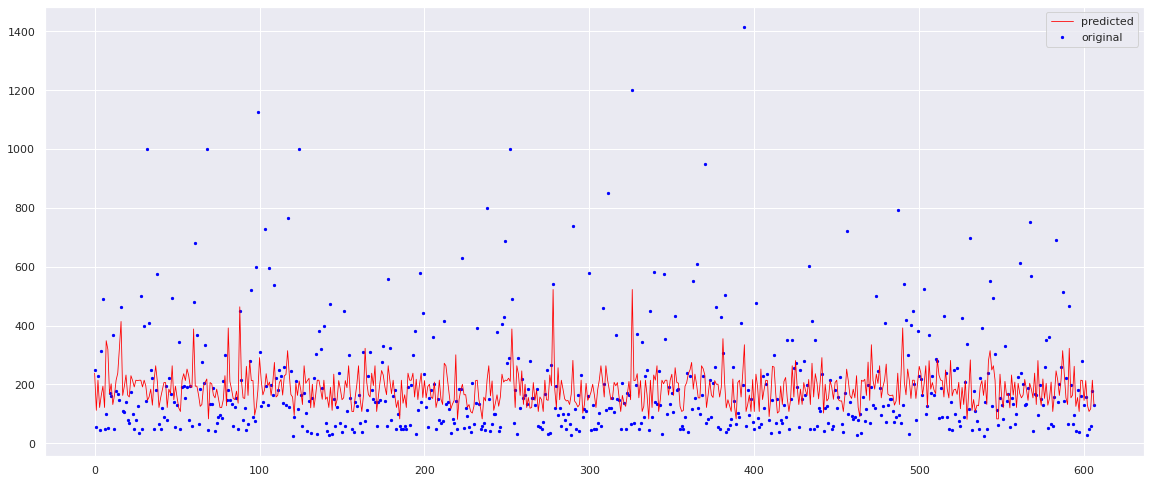

In [78]:
yPredictedTest = booster.predict(X_test)

x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, yPredictedTest, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

R2 VALUE:0.14884626934919853
RMSE VALUE:170.79661306640452


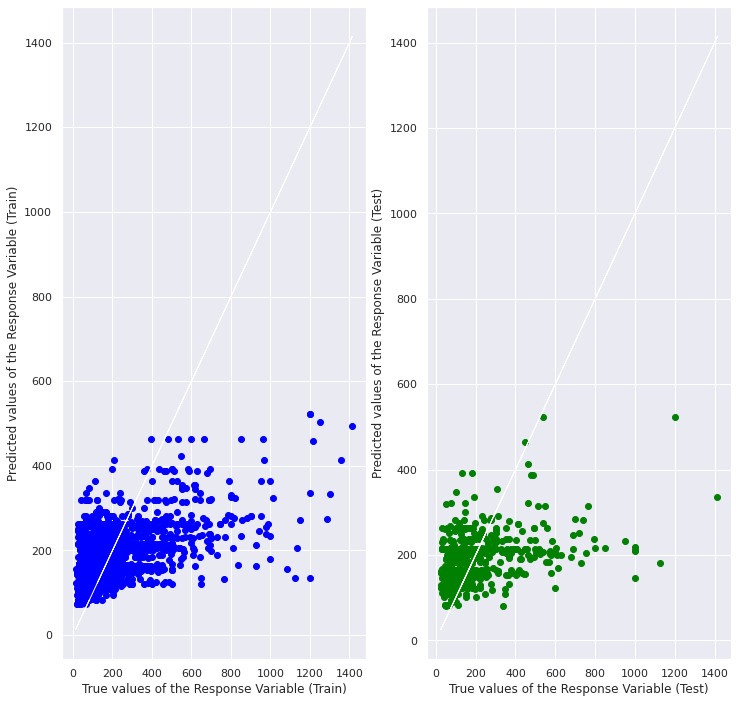

In [79]:

    # Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].scatter(y_train, yPredictedTrain, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, yPredictedTest, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
print("R2 VALUE:" + str(r2_score(y_test, yPredictedTest)))
print("RMSE VALUE:" + str(XGRMSE))



### R Score
While the R2score has dramatically increased, it is still a far cry away from the R2score of 'bedrooms'
Therefore, we will try cross validation

## XGBoost
We'll try to use XGBoost to craft a better regression model of all the variables against price, as XGBoost can be used directly for regression. Here we use XGBoost to see which variable has the most importance

In [80]:

y = pd.DataFrame(combined['price'])
X = combined[TESTVARIABLES2]

    # Split the Dataset into random Train and Test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#for multivar
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
booster = xgb.XGBRegressor()
# In order to find best estimator for parameters during the search,
# create Grid
params = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
          'gamma': [0.0, 0.1, 0.2],
              'colsample_bytree': [0.6, 0.7, 1],
              }

# instantiate the tuned random forest
bgs = GridSearchCV(booster, params, cv=3, n_jobs=-1)

# train the tuned random forest
bgs.fit(X_train, y_train)

bgs.best_params_

[15:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 200}

In [81]:
booster = xgb.XGBRegressor(colsample_bytree=bgs.best_params_['colsample_bytree'],
                           gamma=bgs.best_params_['gamma'],
                           learning_rate=bgs.best_params_['learning_rate'], 
                           max_depth=bgs.best_params_['max_depth'],
                           n_estimators=bgs.best_params_['n_estimators'],
                           random_state=4)
booster.fit(X_train, y_train)

[15:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7,
             n_estimators=200, random_state=4)

In [82]:
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)
r2_score(y_test, y_pred_test)

0.6598195666093405

**CROSS VALIDATION**

In [83]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)
params = {'colsample_bytree':bgs.best_params_['colsample_bytree'], 
          'gamma':bgs.best_params_['gamma'], 
          'learning_rate':bgs.best_params_['learning_rate'], 
          'max_depth':bgs.best_params_['max_depth']}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=bgs.best_params_['n_estimators'], early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [84]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       248.248703        2.736158      248.719767       5.462579
1       239.090119        2.785642      240.178299       5.384612
2       230.404668        2.754023      232.028956       5.388986
3       222.273453        2.789320      224.386373       5.378336
4       214.291580        2.707444      217.473730       5.497786

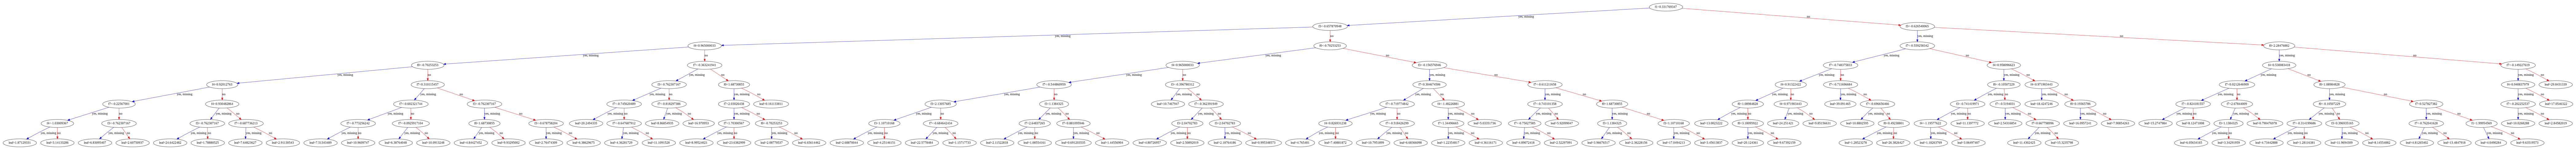

In [85]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(150, 150))
xgb.plot_tree(booster, num_trees=4, ax=ax)
plt.show()

In XGBoost, each of its trees learns from its predecessors to reduce the errors of the previous tree.
Using the feature_importance feature, we are able to determine the importance of each feature


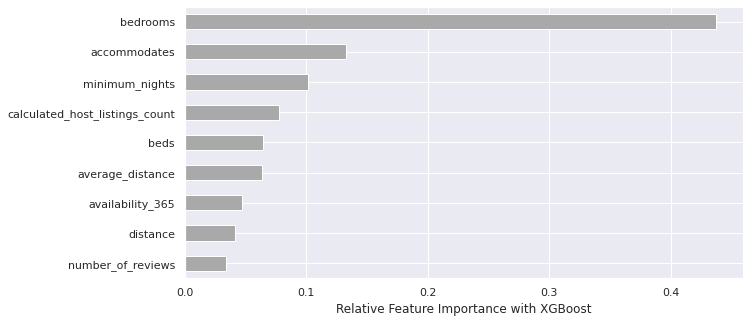

In [86]:
feat_importances = pd.Series(booster.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

We can conclude that for XGboost model, average distance is not a significant feature of importance as it is only 14th in relative importance.

In [87]:
MULTIXGRMSE = mean_squared_error(y_test, yPredictedTest, squared=False)
MULTIXGRMSE

194.9316415303378

R2 VALUE:0.6598195666093405
RMSE VALUE:194.9316415303378


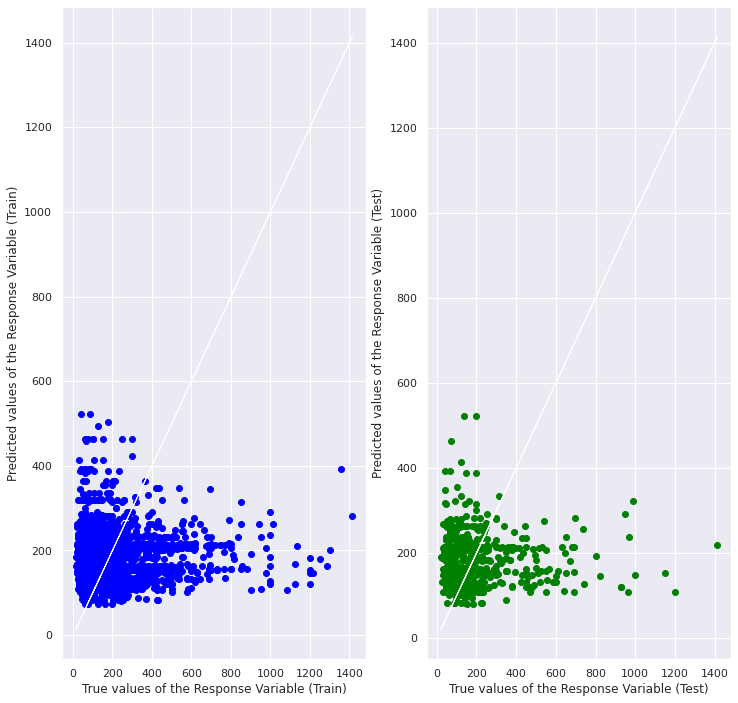

In [88]:
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].scatter(y_train, yPredictedTrain, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, yPredictedTest, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
print("R2 VALUE:" + str(r2_score(y_test, y_pred_test)))
print("RMSE VALUE:" + str(MULTIXGRMSE))

### Oh no..
Using XGBoost to weigh the best features, when distances is compared to the other metrics, it just does not perform at all, coming in at 2nd lowest.


## Model: Random Forest Regression

Let's try another model, random forest regression. Linear regression is a linear model, which means it works really nicely when the data has a linear shape but will perform worse when the problem is not linear, however random forest regression can do well with non-linear variables

In [89]:
from sklearn.ensemble import RandomForestRegressor

In [90]:

y = pd.DataFrame(combined['price'])
X = combined[TESTVARIABLES2]

    # Split the Dataset into random Train and Test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#for multivar
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)


In [91]:
model = RandomForestRegressor(random_state = 0)
param_grid = { 
            "n_estimators"      : [20,30,50],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [4,6,8],
            }

grid = GridSearchCV(model, param_grid, n_jobs=-1, cv=5)
grid.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid.score(X_test, y_test)))

print(grid.best_params_)

best logistic regression from grid search: 0.587
{'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 50}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [92]:
model = RandomForestRegressor(n_estimators = 50, min_samples_split = 4, random_state = 0)
model.fit(X_train, y_train)
    
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_test_pred)
rf_rmse = np.sqrt(rf_mse)
print('rf_rmse', rf_rmse) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


rf_rmse 123.50240295093856


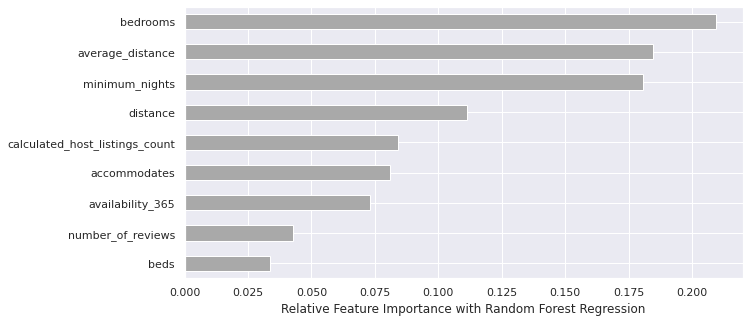

In [93]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest Regression');

Thus we can conclude that average_distance is an important variable for price as it is 2nd in importance. 

In [94]:
TREERMSE = mean_squared_error(y_test, y_test_pred, squared=False)
TREERMSE  

123.50240295093856

R2 VALUE:0.534855485012991
RMSE VALUE:123.50240295093856


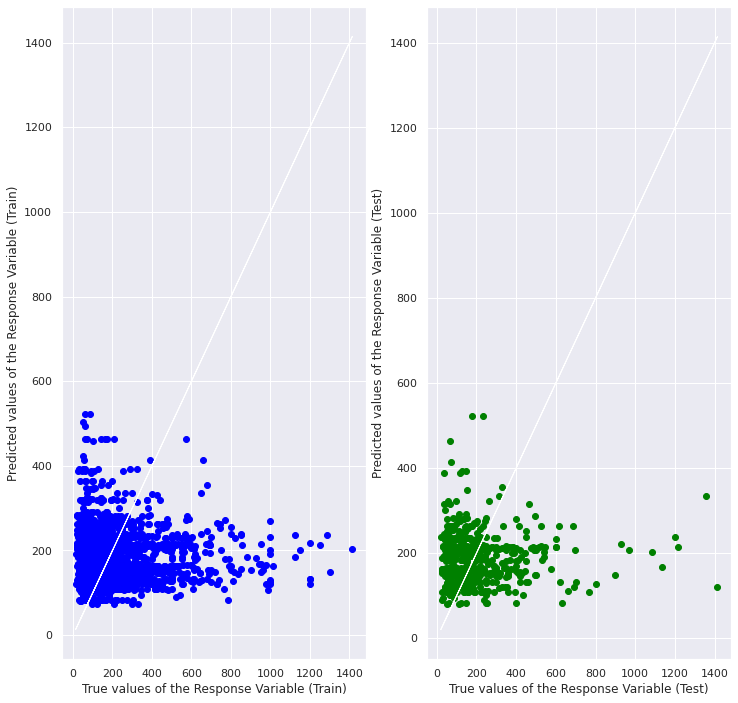

In [95]:
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].scatter(y_train, yPredictedTrain, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, yPredictedTest, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
print("R2 VALUE:" + str(r2_score(y_test, y_test_pred)))
print("RMSE VALUE:" + str(TREERMSE))

## Model: Support Vector Machine

Using Support Vector Machine to try to improve the accuracy of predictions.

Kernels used are radial basis function and sigmoid. As rbf kernel performed better, it will be used to represent the results for the support vector machine model. 

In [96]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

SVMRMSE=[]

y = pd.DataFrame(combined['price'])
x = combined[['distance', 'average_distance','accommodates','bedrooms','beds','minimum_nights','availability_365','number_of_reviews','calculated_host_listings_count']]

print("Kernel: rbf")
for column in x:
  cVal = x[column]
  X = pd.DataFrame(combined[column])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
  clf = svm.SVC(kernel="rbf")
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
  print("Accuracy of {}:".format(column), metrics.accuracy_score(y_test, y_pred))
  print("RMSE of {}:".format(column), mean_squared_error(y_test, y_pred, squared=False))
  print("\n")

X = enc_df1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of neighbourhood_cleansed:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of neighbourhood_cleansed:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

X = enc_df2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of neighbourhood_group_cleansed:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of neighbourhood_group_cleansed:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

X = enc_df3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of property_type:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of Accuracy of property_type:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

X = enc_df4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of room_type:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of room type:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")


print("Kernel: sigmoid")
for column in x:
  cVal = x[column]
  X = pd.DataFrame(combined[column])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
  clf = svm.SVC(kernel="sigmoid")
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
  print("Accuracy of {}:".format(column), metrics.accuracy_score(y_test, y_pred))
  print("RMSE of {}:".format(column), mean_squared_error(y_test, y_pred, squared=False))
  print("\n")

X = enc_df1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="sigmoid")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of neighbourhood_cleansed:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of neighbourhood_cleansed:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

X = enc_df2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="sigmoid")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of neighbourhood_group_cleansed:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of neighbourhood_group_cleansed:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

X = enc_df3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="sigmoid")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of property_type:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of Accuracy of property_type:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

X = enc_df4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=109)
clf = svm.SVC(kernel="sigmoid")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
SVMRMSE.append(mean_squared_error(y_test, y_pred, squared=False)) 
print("Accuracy of room_type:", metrics.accuracy_score(y_test, y_pred))
print("RMSE of room type:", mean_squared_error(y_test, y_pred, squared=False))
print("\n")

Kernel: rbf
Accuracy of distance: 0.03789126853377265
RMSE of distance: 198.90684365977762


Accuracy of average_distance: 0.039538714991762765
RMSE of average_distance: 195.33517006818911


Accuracy of accommodates: 0.03130148270181219
RMSE of accommodates: 149.92751680909134


Accuracy of bedrooms: 0.018121911037891267
RMSE of bedrooms: 174.38248782291205


Accuracy of beds: 0.023064250411861616
RMSE of beds: 170.28936512534796


Accuracy of minimum_nights: 0.016474464579901153
RMSE of minimum_nights: 199.53168399023807


Accuracy of availability_365: 0.03130148270181219
RMSE of availability_365: 191.11486407010253


Accuracy of number_of_reviews: 0.019769357495881382
RMSE of number_of_reviews: 200.63007423771896


Accuracy of calculated_host_listings_count: 0.029654036243822075
RMSE of calculated_host_listings_count: 157.4322740818096


Accuracy of neighbourhood_cleansed: 0.060955518945634266
RMSE of neighbourhood_cleansed: 162.5742258560235


Accuracy of neighbourhood_group_cleanse

In [97]:
print("Lowest RMSE: ", min(SVMRMSE))

Lowest RMSE:  149.92751680909134


Accommodates variables with rbf kernel produces the lowest RMSE.

## Model: ElasticNet Regression
ElasticNet is similar to linear regression method call, except it can be tuned using an alpha value, which ElasticNet itself can calculate

average_distance
Intercept of Regression 	: b =  [254.92702806]
Coefficients of Regression 	: a =  [-0.00868135]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.035388653540637804
Mean Squared Error (MSE) 	: 30154.339281555178

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.029458627582709562
Mean Squared Error (MSE) 	: 34972.09377993013



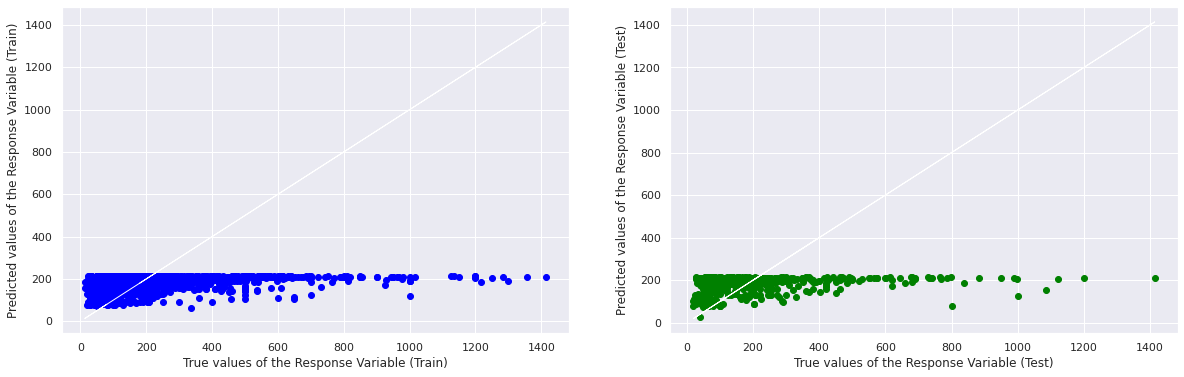

distance
Intercept of Regression 	: b =  [213.76588047]
Coefficients of Regression 	: a =  [-0.02152567]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.022463592544667343
Mean Squared Error (MSE) 	: 31347.32327108766

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.029624753310264818
Mean Squared Error (MSE) 	: 31852.309901722536



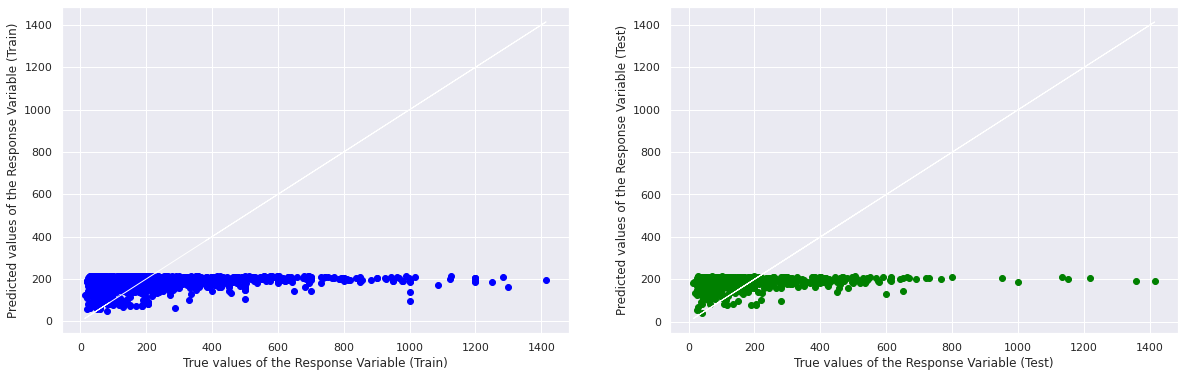

accommodates
Intercept of Regression 	: b =  [57.11474472]
Coefficients of Regression 	: a =  [48.35181384]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.23055033794741475
Mean Squared Error (MSE) 	: 24641.76144485096

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.2662119922342788
Mean Squared Error (MSE) 	: 24232.597734345654



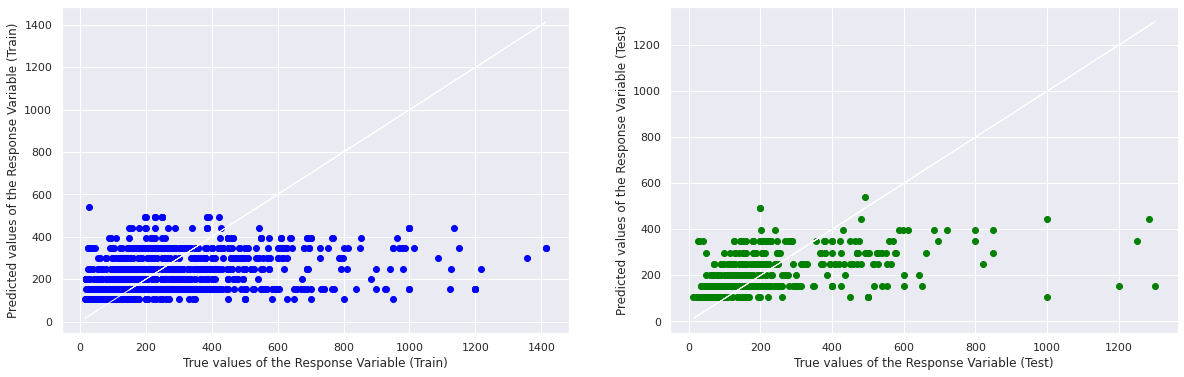

bedrooms
Intercept of Regression 	: b =  [30.69129507]
Coefficients of Regression 	: a =  [118.31738477]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2213174366521906
Mean Squared Error (MSE) 	: 23738.234418557702

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.19248660251427585
Mean Squared Error (MSE) 	: 31635.129768158706



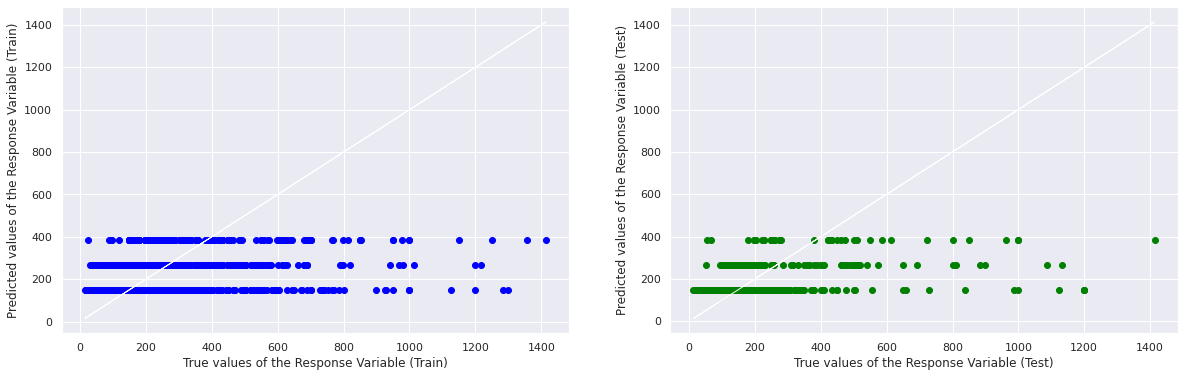

beds
Intercept of Regression 	: b =  [88.17677682]
Coefficients of Regression 	: a =  [59.52028111]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.13868464484935006
Mean Squared Error (MSE) 	: 26595.028162403578

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.11893401286901295
Mean Squared Error (MSE) 	: 32972.385867011726



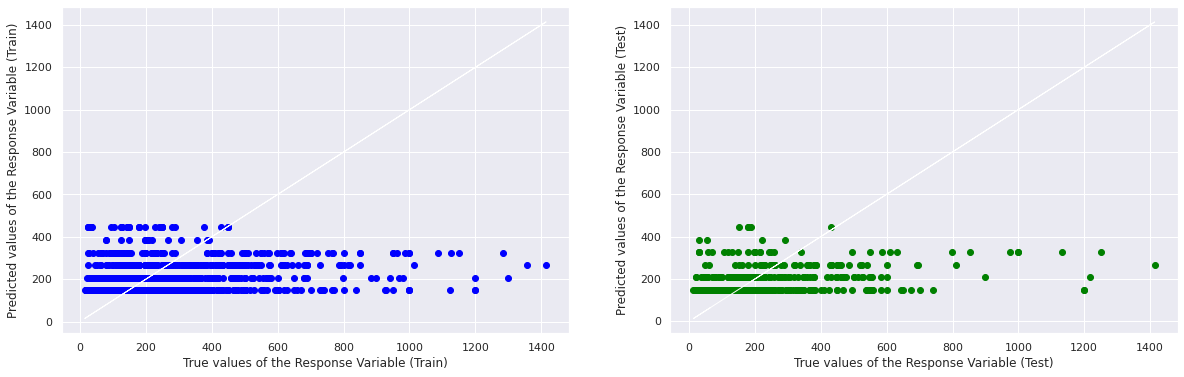

minimum_nights
Intercept of Regression 	: b =  [220.78493066]
Coefficients of Regression 	: a =  [-0.86300975]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.051446110105326404
Mean Squared Error (MSE) 	: 31236.612007997548

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.026303261853226734
Mean Squared Error (MSE) 	: 28634.088138562463



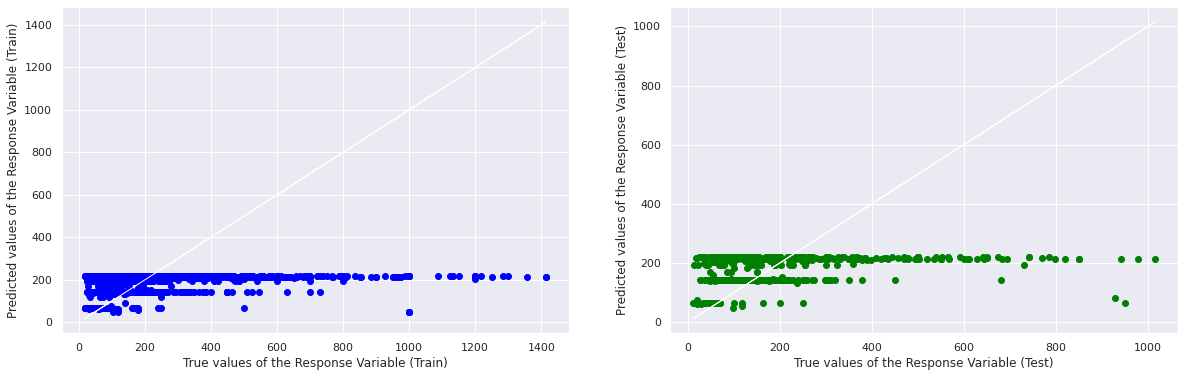

availability_365
Intercept of Regression 	: b =  [142.67612014]
Coefficients of Regression 	: a =  [0.19777405]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.026257256876446866
Mean Squared Error (MSE) 	: 30823.75810513539

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.01705722777367913
Mean Squared Error (MSE) 	: 33920.17751983448



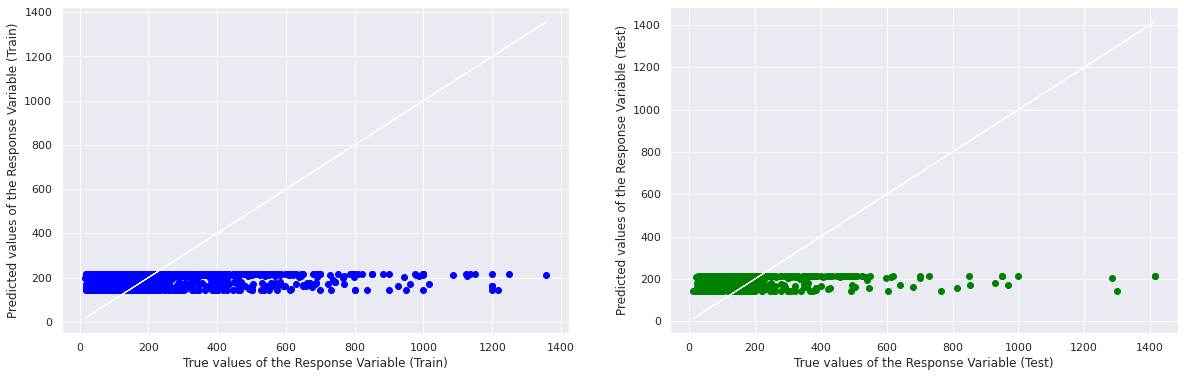

number_of_reviews
Intercept of Regression 	: b =  [199.75925031]
Coefficients of Regression 	: a =  [-1.27209428]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.016789302238129244
Mean Squared Error (MSE) 	: 31941.382045001406

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.0025531118450137225
Mean Squared Error (MSE) 	: 31051.98169197739



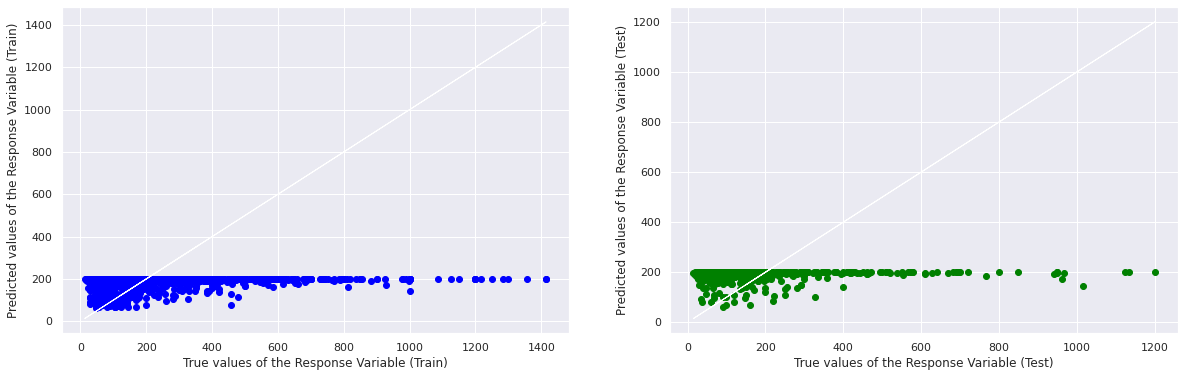

calculated_host_listings_count
Intercept of Regression 	: b =  [156.74179459]
Coefficients of Regression 	: a =  [0.74547445]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0651904041189415
Mean Squared Error (MSE) 	: 30743.23826211112

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.10223219626132696
Mean Squared Error (MSE) 	: 26464.918619422027



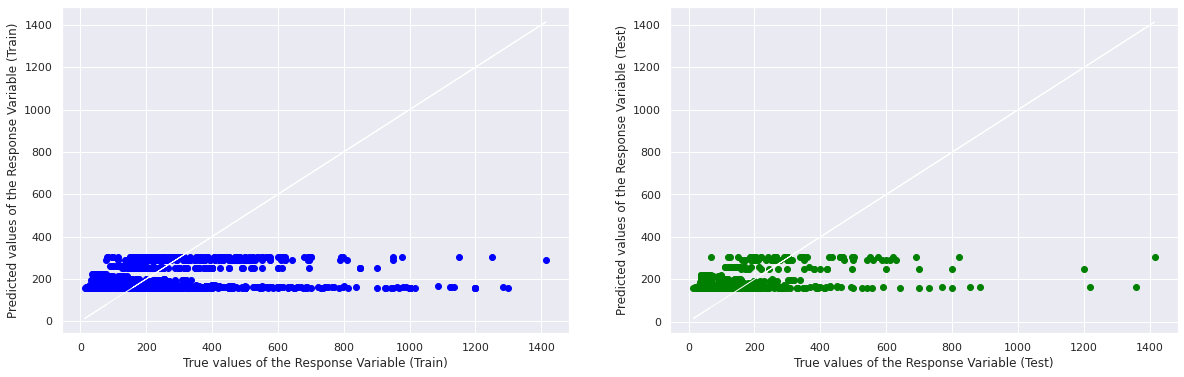

neighbourhood_cleansed
Intercept of Regression 	: b =  [188.00576606]
Coefficients of Regression 	: a =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0
Mean Squared Error (MSE) 	: 33377.353344017756

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -5.1864096622056266e-05
Mean Squared Error (MSE) 	: 27621.646388645375



neighbourhood_group_cleansed
Intercept of Regression 	: b =  [188.79859967]
Coefficients of Regression 	: a =  [0. 0. 0. 0. 0.]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0
Mean Squared Error (MSE) 	: 31205.847823409753

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0007340643384703416
Mean Squared Error (MSE) 	: 36312.70923401203



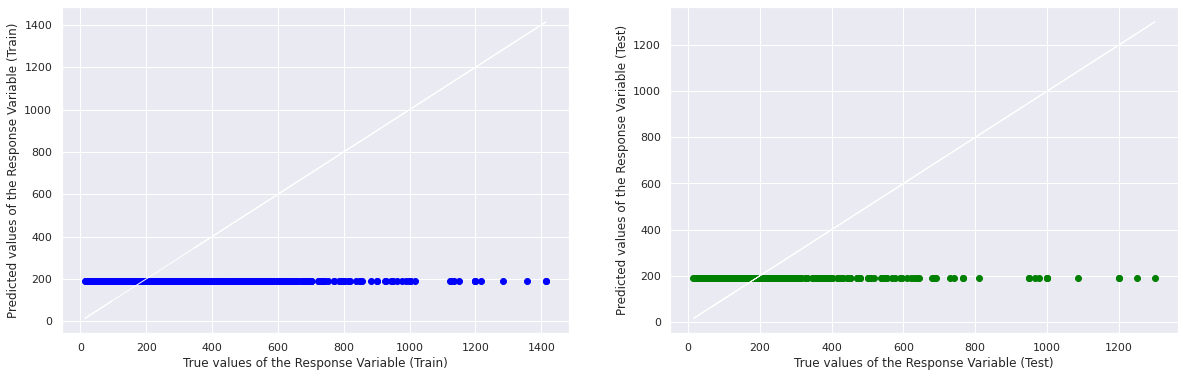

property_type
Intercept of Regression 	: b =  [189.34596376]
Coefficients of Regression 	: a =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0
Mean Squared Error (MSE) 	: 32689.381132802642

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0020570342841268463
Mean Squared Error (MSE) 	: 30385.72396722477



room_type
Intercept of Regression 	: b =  [188.73228995]
Coefficients of Regression 	: a =  [0. 0. 0. 0.]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0
Mean Squared Error (MSE) 	: 33156.67956691428

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.000818804378274196
Mean Squared Error (MSE) 	: 28508.71979093443



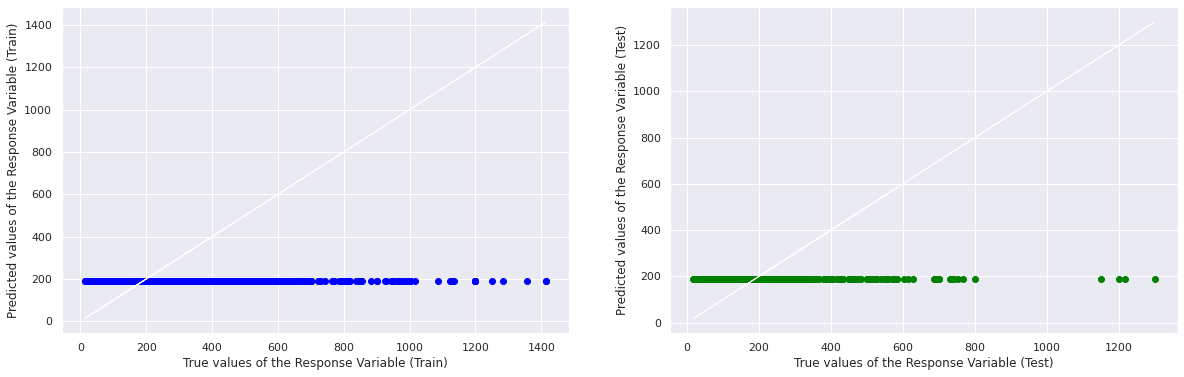

'\nfor key, value in TESTVARIABLES_ONE_HOT.items():\n  enc = OneHotEncoder(sparse=False)\n  X_transform = enc.fit_transform(gp.GeoDataFrame(combined, columns = value))\n\n  #tbappend = univariateLinearRegression(Xvar = X_transform, yvar = combined["price"])\n  #result[key]=tbappend\n\n  X_train, X_test, y_train, y_test = train_test_split(X_transform, combined["price"], test_size = 0.2)\n\n  linreg = LinearRegression(fit_intercept=False)\n  linreg.fit(X_train, y_train)\n\n  result[key] = linreg.score(X_train, y_train)\n'

In [98]:
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error,r2_score

def elasticNet(Xvar = None, yvar = None, df = None, title = None):
  if isinstance(Xvar, str):
    X = pd.DataFrame(df[Xvar])
  else:
    X = Xvar
  if isinstance(yvar, str):
    y = pd.DataFrame(df[yvar])
  else:
    y = yvar
  
  #response = pd.DataFrame(responseData)          # Response
  #predictor = pd.DataFrame(predictorData)        # Predictor

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  # Tune elastic
  elastic_cv = ElasticNetCV(cv = 10).fit(X_train,y_train)
  tuned_elastic = ElasticNet(alpha = elastic_cv.alpha_).fit(X_train, y_train)

  if title is None:
    print('\033[1m' + Xvar + '\033[0m')
  else:
    print('\033[1m' + title + '\033[0m')
  
  # Coefficients of the Linear Regression line
  print('Intercept of Regression \t: b = ', tuned_elastic.intercept_)
  print('Coefficients of Regression \t: a = ', tuned_elastic.coef_)
  print()
  
  # Formula for the Regression line
  regline_x = X_train
  regline_y = tuned_elastic.intercept_ + tuned_elastic.coef_ * X_train

  # y_test_pred
  y_train_pred = tuned_elastic.predict(X_train)
  y_test_pred = tuned_elastic.predict(X_test)

  # Check the Goodness of Fit (on Train Data)
  print("Goodness of Fit of Model \tTrain Dataset")
  print("Explained Variance (R^2) \t:", tuned_elastic.score(X_train, y_train))
  print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
  print()

  # Check the Goodness of Fit (on Test Data)
  print("Goodness of Fit of Model \tTest Dataset")
  print("Explained Variance (R^2) \t:", tuned_elastic.score(X_test, y_test))
  print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
  print()
  
  # Plot the Predictions vs the True values
  f, axes = plt.subplots(1, 2, figsize=(20, 6))
  axes[0].scatter(y_train, y_train_pred, color = "blue")
  axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
  axes[0].set_xlabel("True values of the Response Variable (Train)")
  axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
  axes[1].scatter(y_test, y_test_pred, color = "green")
  axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
  axes[1].set_xlabel("True values of the Response Variable (Test)")
  axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

  plt.show()
  return mean_squared_error(y_test, y_test_pred, squared=False)

TESTVARIABLES=['average_distance','distance','accommodates','bedrooms','beds','minimum_nights','availability_365','number_of_reviews','calculated_host_listings_count']

elastic_result = {}
for x in TESTVARIABLES:
  elastic_result[x] = elasticNet(Xvar = x, yvar = "price", df = combined)

TESTVARIABLES_ONE_HOT = {
    "neighbourhood_cleansed": enc_df1.columns.values,
    'neighbourhood_group_cleansed': enc_df2.columns.values,
    'property_type': enc_df3.columns.values,
    'room_type': enc_df4.columns.values
}
for key, value in TESTVARIABLES_ONE_HOT.items():
  enc = OneHotEncoder(sparse=False)
  X_transform = enc.fit_transform(gp.GeoDataFrame(combined, columns = value))
  elastic_result[key] = elasticNet(Xvar = X_transform, yvar = "price", df = combined, title = key)

"""
for key, value in TESTVARIABLES_ONE_HOT.items():
  enc = OneHotEncoder(sparse=False)
  X_transform = enc.fit_transform(gp.GeoDataFrame(combined, columns = value))

  #tbappend = univariateLinearRegression(Xvar = X_transform, yvar = combined["price"])
  #result[key]=tbappend

  X_train, X_test, y_train, y_test = train_test_split(X_transform, combined["price"], test_size = 0.2)

  linreg = LinearRegression(fit_intercept=False)
  linreg.fit(X_train, y_train)

  result[key] = linreg.score(X_train, y_train)
"""


### Model: ElasticNet Regression Conclusion##




In [99]:
palette = sb.color_palette("husl", len(elastic_result))
ind = np.arange(len(elastic_result))
plt.barh(ind, list(elastic_result.values()), color=palette)
plt.yticks(ind, list(elastic_result.keys()))
plt.xlabel('ElasticNet RMSE')

Text(0.5, 0, 'ElasticNet RMSE')

Accommodates produced the lowest RMSE!

# Conclusion

### Comparison of the RMSE generated by the models on the Average Distance

Text(0.5, 0, 'Comparison RMSE')

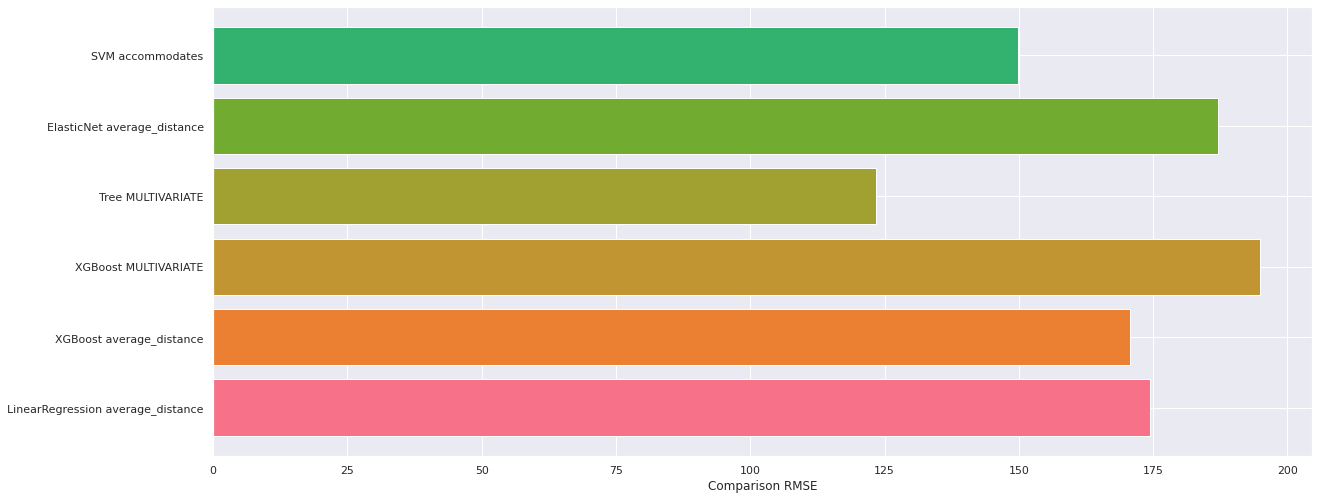

In [100]:
RMSECOMPARE = {}
RMSECOMPARE['LinearRegression average_distance'] = result['average_distance']
RMSECOMPARE['XGBoost average_distance'] = XGRMSE
RMSECOMPARE['XGBoost MULTIVARIATE'] =MULTIXGRMSE
RMSECOMPARE['Tree MULTIVARIATE'] =TREERMSE
RMSECOMPARE['ElasticNet average_distance'] =elastic_result['average_distance']
RMSECOMPARE['SVM accommodates'] = min(SVMRMSE)
ind = np.arange(len(RMSECOMPARE))
plt.barh(ind, list(RMSECOMPARE.values()), color=palette)
plt.yticks(ind, list(RMSECOMPARE.keys()))
plt.xlabel('Comparison RMSE')

Random Forest performs the best out of all the models in using Average Distance as a predictor for the price of Airbnbs.

### Outcome & Insights

Although it was initially predicted that there might be a correlation between the distance between Airbnb and tourist attractions, the machine learning models failed to show that average distance would be a reliable predictor of the price of Airbnb. The only exception would be the random forest model which performed better in using the average distance as a predictor. It was also discovered that price and distance might not be linearly related as all other models of regression performed better.

Explanations as to why the the distance did not have an obvious relationship with the price of Airbnb could be due to the small size of Singapore that the presence of nearby tourist attractions may not affect the price. However, Airbnbs located near the central where there is a cluster of tourist attractions did have higher prices, though there could be other factors at play as well that would cause the increase in price. Hence, the variables that were found that were the best at predicting the price are beds, bedrooms and accommodates as they are variables that imply a larger living space and therefore increasing the price of Airbnbs. 

Further research could be done to see if the size of Airbnb would be the best indicator in predicting the price as the dataset that was used did not contain such information. 